In [180]:
# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Маркетинг.

**Введение**

В рамках проекта для интернет-магазина мы проанализируем имеющуюся историю покупок клиентов, чтобы решить задачу идентификации пользователей, которые проявляют интерес и готовы совершить покупку в ближайшее время. Это поможет повысить эффективность планирования заказчиком будущих маркетинговых кампаний.

**Цель**

Предсказать вероятность покупки в течение 90 дней.

**Данные**

Данные представлены тремя файлами, предоставленными заказчиком:

`apparel_purchases` - данные об истории покупок:
- `client_id` идентификатор пользователя;
- `quantity` количество товаров в заказе;
- `price` цена товара;
- `category_ids` вложенные категории, к которым отнсится товар;
- `date` дата покупки;
- `message_id` идентификатор сообщения из рассылки.

`apparel_messages` история рекламных рассылок:
- `bulk_campaign_id` идентификатор рекламной кампании;
- `client_id` идентификатор пользователя;
- `message_id` идентификатор сообщений;
- `event` тип действия;
- `channel` канал рассылки;
- `date` дата рассылки;
- `created_at` точное время создания сообщения.

`apparel_target_binary` совершит ли клиент покупку в течение следующих 90 дней:
- `client_id` идентификатор пользователя;
- `target` целевой признак.

**План работы**
- Загрузим данные и проведем их первичную обработку: оценим соответствие типов данных, наличие пропущенных значений и дубликатов.
- Проведем исследовательский анализ, чтобы выявить основные закономерности данных, определить наличие выбросов и аномалий.
- Далее, сагрегируем имеющиеся данные, при необходимости, создадим новые синтетические признаки. Проведем корелляционный анализ, чтобы составить представление о взаимосвязях между признаками.
- Обучим модели машинного обучения с фокусом на метрику roc-auc по требованию заказчика. Проанализируем матрицы ошибок и выберем наиболее подходящую для поставленной задачи.
- Совершим итоговое предсказание, определим клиентов, готовых совершить покупку.
- Проанализируем важность признаков, определим ключевые закономерности для клиентов, готовых совершить покупку и клиентов, которые за покупкой не вернутся.
- Подведем общий итог работы, составим рекомендации для заказчика.

## Инициализация

### Загрузим библиотеки

In [1]:
# !pip install shap
# !pip install scikit-learn==1.2.2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import(train_test_split,
                                    StratifiedKFold,
                                    GridSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from category_encoders import CountEncoder


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (roc_auc_score, 
                             f1_score, 
                             confusion_matrix,
                             precision_score, 
                             recall_score,
                             precision_recall_curve)
import phik
import shap

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Объявим константы

In [3]:
RANDOM_STATE = 77

### Создадим функции

In [4]:
def format_dataset(df):
    obj_cols = df.select_dtypes(include=['object']).columns
    df[obj_cols] = df[obj_cols].apply(lambda x: x.str.lower().str.strip())
    df.replace(['nan', 'none', 'null', '', 'n/a', 'n.a.', 'missing', 'undefined', 'unknown'], np.nan, inplace=True)
    return df

In [5]:
def normal_range (data, column):
    describe_column = data[column].describe()
    IQR = (describe_column['75%'] - describe_column['25%']) * 1.5
    normal_min = round(describe_column['25%'] - IQR, 2)
    normal_max = round(describe_column['75%'] + IQR, 2)
    if normal_min < data[column].min():
        normal_min = round(data[column].min(), 2)
    elif normal_max > data[column].max():
        normal_max = round(data[column].max(), 2)
    return normal_min, normal_max

In [6]:
def num_cols_analysis(data, column):
    fig, axs = plt.subplots(2, figsize=(8, 8))
    fig.suptitle(f'Анализ значений столбца "{column}"')

    sns.histplot(data[column], bins=50, ax=axs[0])
    axs[0].set_xlabel(f'Значения "{column}"')
    axs[0].set_ylabel('Частота')
    axs[0].grid(True)

    sns.boxplot(x=data[column], ax=axs[1])
    axs[1].set_xlabel(f'Значения "{column}"')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [7]:
def cat_cols_analysis (data, column):
    plt.figure(figsize=(8, 6))
    plt.title(f'Соотношение признаков в столбце {column}')
    data[column].value_counts().plot(kind='pie', autopct='%1.0f%%')
    plt.ylabel('')
    plt.show()

    return data[column].value_counts()

In [8]:
def discret_cols_analysis(data, column):
    plt.figure(figsize=(10, 6))
    plt.title(f'Анализ значений столбца "{column}"')
    sns.countplot(x=data[column], order=data[column].value_counts().index)
    plt.xticks(rotation=90)
    plt.xlabel(f'Значения "{column}"')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

In [9]:
def confusion_matrix_comp (y_test, y_pred_cb, y_pred_cb_corr, y_pred_lgbm, y_pred_lgbm_corr):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sns.heatmap(confusion_matrix(y_test, y_pred_cb), annot=True, fmt='d', cmap='Blues_r', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix модели CatBoost до настройки')
    axes[0, 0].set_ylabel('Истинное значение класса')
    axes[0, 0].set_xlabel('Предсказанное значение класса')

    sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d', cmap='Blues_r', ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix модели LGBM до настройки')
    axes[0, 1].set_ylabel('Истинное значение класса')
    axes[0, 1].set_xlabel('Предсказанное значение класса')

    sns.heatmap(confusion_matrix(y_test, y_pred_cb_corr), annot=True, fmt='d', cmap='Blues_r', ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix модели CatBoost после настройки')
    axes[1, 0].set_ylabel('Истинное значение класса')
    axes[1, 0].set_xlabel('Предсказанное значение класса')

    sns.heatmap(confusion_matrix(y_test, y_pred_lgbm_corr), annot=True, fmt='d', cmap='Blues_r', ax=axes[1, 1])
    axes[1, 1].set_title('Confusion Matrix модели LGBM после настройки')
    axes[1, 1].set_ylabel('Истинное значение класса')
    axes[1, 1].set_xlabel('Предсказанное значение класса')

    plt.tight_layout()
    plt.show()

In [10]:
def shap_scatter(feature):
    fig, ax = plt.subplots()
    plt.title(f'Граница значения признака "{feature}" для прогноза.')
    ax.grid()
    shap.plots.scatter(shap_values[:,feature], ax=ax)

In [11]:
def shap_scatter_comp(feature_1, feature_2):
    fig, ax = plt.subplots()
    plt.title(f'Граница значения признака "{feature_1}" для прогноза.')
    ax.grid()
    plt.axhline(y=0, color='grey', linewidth=2.5)
    shap.dependence_plot(feature_1, shap_values.values, X_train, interaction_index=feature_2, alpha=0.2, ax=ax)

## Загрузка данных

Загрузим данные, проверим корректность чтения.

In [12]:
purchases = pd.read_csv(r"C:\Users\ПК\Desktop\DS\Мастерская_2\filtered_data\apparel-purchases.csv", parse_dates=['date'])
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [13]:
messages = pd.read_csv(r"C:\Users\ПК\Desktop\DS\Мастерская_2\filtered_data\apparel-messages.csv", parse_dates=['date','created_at'])
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [14]:
target = pd.read_csv(r"C:\Users\ПК\Desktop\DS\Мастерская_2\filtered_data\apparel-target_binary.csv")
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Данные успешно загружены.

## Предварительная обработка данных

Отформатируем данные датасетов: приведем все строки к нижнему регистру, избавимся от возможных пробелов в начале и в конце строк, заменим возможные варианты пропущенных значений на NaN.

In [15]:
purchases = format_dataset(purchases)
messages = format_dataset(messages)

### Purchases

Датасет содержит данные об истории покупок.
- `client_id` идентификатор пользователя
- `quantity` количество товаров в заказе
- `price` цена товара
- `category_ids` вложенные категории, к которым отнсится товар
- `date` дата покупки
- `message_id` идентификатор сообщения из рассылки

In [16]:
purchases.head(2)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d


Ознакомимся с общей информацией о датасете.

In [17]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Пропущенные значения отсутствуют, формат данных соответствует содержащимся значениям. Признак `category_ids` представлен строкой с вложенными подкатегориями, его значения мы рассмотрим подробнее на этапе исследовательского анализа данных.

Проверим датасет на наличие полных дубликатов.

In [18]:
purchases.duplicated().sum()

73020

Оценим долю дубликатов в датасете, узнаем, сколько клиентов имеют дублирующиеся заказы.

In [19]:
f'Дубликаты составляют {(purchases.duplicated().sum() / purchases.shape[0]):.1%} датасета.'

'Дубликаты составляют 36.1% датасета.'

In [20]:
f'Доля клиентов с дублирующимися заказами: {(purchases[purchases.duplicated()].client_id.unique().shape[0] / purchases.client_id.unique().shape[0]):.1%}'

'Доля клиентов с дублирующимися заказами: 54.6%'

Дублирующиеся строки составляют около трети всех данных, более половины клиентов имеют дублирующиеся строки. Дубликаты в данном случае означают, что один клиент совершил несколько покупок одного и того же товара в один и тот же день. 

Клиент действительно может оформить несколько одинаковых заказов в день, например, по техническим причинам (клиент не увидел подтверждение заказа и оформил еще один), или клиент забыл указать нужное количество единиц товара при первом заказе (нужно было два, а заказал один). Возможно, клиент не умеет настраивать количество единиц товара в одном заказе, и заказывает товары по-одному. Однако эти ситуации обычно не имеют столь системного характера.

Поскольку нам не хватает информации для наиболее вероятного определения реальных покупок (точное время оформления заказа, конечный статус заказа), чтобы определить правдоподобность дубликатов, изучим следующие показатели:
- сколько, в среднем, строк-дубликатов приходится на одного клиента. 
- изучим количество единиц товара, которое приобретал клиент за одну покупку.
- типична ли ситуация повтора заказа в один день для клиента.

In [21]:
purchases_dup = purchases[purchases.duplicated(keep=False)].pivot_table(
    index=['client_id', 'date'], 
    values=['quantity'], 
    aggfunc=['count', 'sum']
)

In [22]:
purchases_dup.columns=['count_quantity', 'sum_quantity']

In [23]:
purchases_dup.head(10)

count_quantity  sum_quantity
client_id           date                                    
1515915625468060902 2022-05-27               4             4
1515915625468061003 2023-01-04               2             2
1515915625468061100 2024-02-10               2             2
1515915625468061170 2023-03-26               4             4
                    2023-03-29              12            12
                    2023-06-17               3             3
1515915625468061994 2022-12-14               3             3
1515915625468062158 2023-04-28               2             2
1515915625468062184 2023-07-04               4             4
1515915625468062556 2022-11-15               2             2

In [24]:
purchases_dup['count_quantity'].describe()

count    31077.000000
mean         4.237314
std          4.525620
min          2.000000
25%          2.000000
50%          2.000000
75%          6.000000
max        216.000000
Name: count_quantity, dtype: float64

In [25]:
purchases_dup['sum_quantity'].describe()

count    31077.000000
mean         4.243138
std          4.533023
min          2.000000
25%          2.000000
50%          2.000000
75%          6.000000
max        216.000000
Name: sum_quantity, dtype: float64

В среднем, на каждого клиента приходится 2 покупки одной единицы товара в один день. С учетом системности проблемы, такие покупки, вероятнее всего относятся к ошибкам в базе данных, либо к случайным повторным заказам. Вместе с тем, часть клиентов оформляела несколько дублирующихся заказов в разные дни. Остановимся подробнее на этих клиентах. Узнаем, совершали ли эти клиенты заказы, в которых сразу задано нужное количество единиц товара.

In [26]:
# Оставляем только тех клиентов, которые имеют дубликаты с разными датами:
filtered_clients = purchases_dup.reset_index().groupby('client_id').filter(lambda x: x['date'].nunique() > 1)
# Сохраняем их номера id, чтобы далее отфильтровать датасет purchases:
filtered_duplicated_id = filtered_clients['client_id'].unique()

In [27]:
# Агрегируем данные датасета purchases по этим клиентам:
filtered_purchases = purchases[purchases['client_id'].isin(filtered_duplicated_id)].pivot_table(
    index=['client_id', 'date'], 
    values=['quantity'], 
    aggfunc=['count', 'sum']
)
filtered_purchases.columns=['count', 'sum']

In [28]:
# Выбираем тех, кто за один раз заказал несколько товаров.
filtered_purchases[(filtered_purchases['count'] == 1) & (filtered_purchases['sum'] != 1)]

,,count,sum
client_id,date,,
1515915625474553161,2022-06-01,1,2
1515915625478973322,2022-06-05,1,2
1515915625483573218,2022-05-26,1,2
1515915625487645999,2022-06-17,1,3
1515915625489558345,2022-06-22,1,2
1515915625559720800,2022-07-31,1,2
1515915625813799698,2024-01-09,1,2


In [29]:
len(filtered_duplicated_id)

2885

2885 клиентов имеют тенденцию дублировать заказ, чтобы настроить итоговое количество единиц товара. Из них часть клиентов дествительно однократно оформляла заказ сразу на несколько единиц товара, однако в масштабах общей тенденции эти покупки имеют малый вес.

Удалим из нашего датасета все дублирующиеся строки, кроме записей о клиентах, создававших дублирующиеся заказы более одного раза а разные даты.

In [30]:
purchases.shape

(202208, 6)

In [31]:
purchases =  purchases[purchases['client_id'].isin(filtered_duplicated_id) | ~purchases.duplicated()]

In [32]:
purchases.shape

(147168, 6)

### Messages

Датасет содержит данные об истории рекламных рассылок
- `bulk_campaign_id` идентификатор рекламной кампании
- `client_id` идентификатор пользователя
- `message_id` идентификатор сообщений
- `event` тип действия
- `channel` канал рассылки
- `date` дата рассылки
- `created_at` точное время создания сообщения

Ознакомимся с общей информацией о датасете.

In [33]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [34]:
messages.head(2)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34


Типы данных соответствуют, проверим наличие пропусков.

In [35]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропущенных значений нет.

Проверим наличие явных дубликатов. 

In [36]:
messages.duplicated().sum()

48610

В данном случае дубликаты явно содержат некорректные данные: клиентом обработано одно и то же рекламное сообщение в одно и то же время с точностью до секунды. Удалим дублирующиеся строки из датасета.

In [37]:
messages = messages.drop_duplicates() 

Проверим наличие неявных дубликатов в признаках `event` и `channel`.

In [38]:
messages.event.value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

В рамках поставленной задачи нас будут в большей степени интересовать категории "send", "open", "click", "purchase", "subscribe", "unsubscribe" - именно они могут дать информацию о покупательском поведении клиентов, в то время как остальные варианты описывают неконвертируемое в покупки поведение покупателя. Объединим эти категории в группу "other".

In [39]:
messages['event'] = messages['event'].replace(['hard_bounce', 'soft_bounce', 'hbq_spam', 'complain', 'close'], 'other')

In [40]:
messages.event.value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
other            31696
unsubscribe       2833
subscribe           85
Name: count, dtype: int64

Категории успешно объединены. Изучим значения признака `channel`.

In [41]:
messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

В категориях признака `channel` неявных дубликатов нет.

### Промежуточный итог по предобработке данных.

На этапе предварительной обработки мы применили базовое форматирование к обоим датасетам: устранили наиболее частые артефакты строковых данных, заменили возможные варианты обозначения пропусков на NaN.

Пропущенные значения в обоих датасетах отсутствуют.

В датасете `purchase` мы обработали дублирующиеся заказы, оставив лишь наблюдения о клиентах, совершавших одинаковые заказы неоднократно в разные дни.

В датасете `message` мы также обработали явные дубликаты и объединили нерелевантные для задачи категории признака `event`: 'hard_bounce', 'soft_bounce', 'hbq_spam', 'complain', 'close' . 

In [42]:
f'Размерность датасетов после этапа предобработки. Purchases: {purchases.shape}, messages:{messages.shape}.'

'Размерность датасетов после этапа предобработки. Purchases: (147168, 6), messages:(12691188, 7).'

## Исследовательский анализ

### Target

Изучим распределение целевого признака.

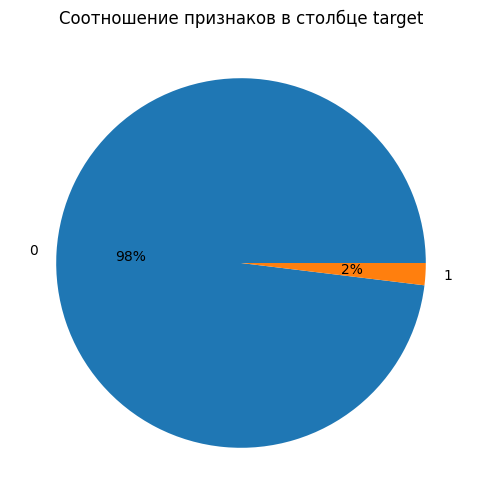

target
0    48888
1      961
Name: count, dtype: int64

In [43]:
cat_cols_analysis(target, 'target')

В категориях целевой переменной мы имеем выраженный дисбаланс, который мы будем учитывать при обучении модели.

### Purchases

Определим, за какой период собраны данные.

In [44]:
f'В датасете `purchases` представлены данные за период с {purchases.date.min()} по {purchases.date.max()}.'

'В датасете `purchases` представлены данные за период с 2022-05-16 00:00:00 по 2024-02-16 00:00:00.'

В нашем распоряжении данные за два года: с мая 2022 по февраль 2024.

Проанализируем значения цены и количества покупок.

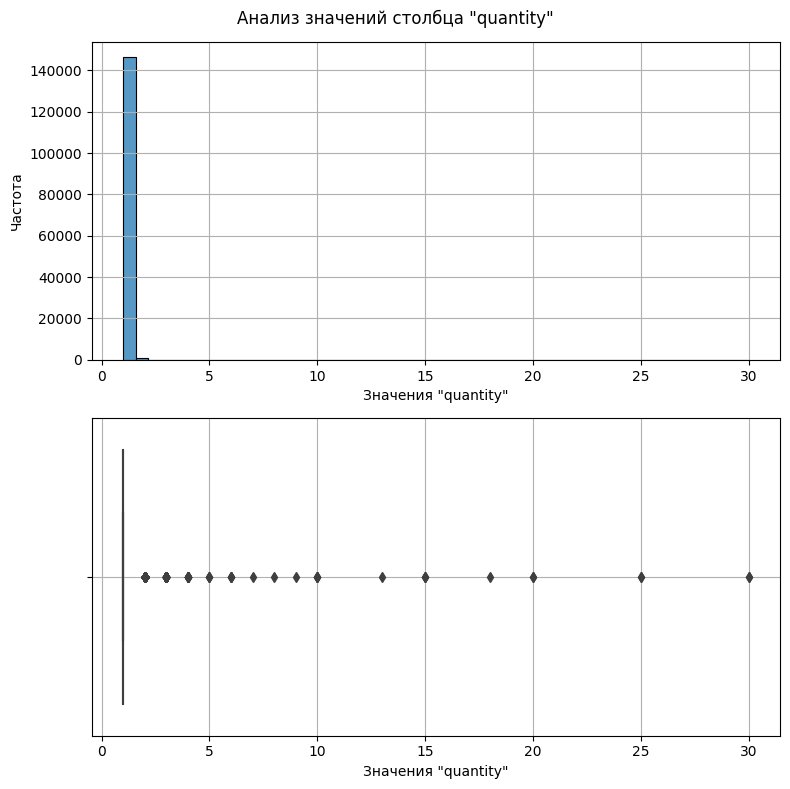

In [45]:
num_cols_analysis(purchases, 'quantity')

На графике мы видим наличие выбросов по данному признаку. Рассчитаем диапозон нормальных значений.

In [46]:
purchases_quantity_norm_min, purchases_quantity_norm_max = normal_range(purchases, 'quantity')

In [47]:
purchases_quantity_norm_min, purchases_quantity_norm_max

(1.0, 1.0)

Большая часть товаров покупалась по одной единице в заказе. Проанализируем значения цены единицы товара.

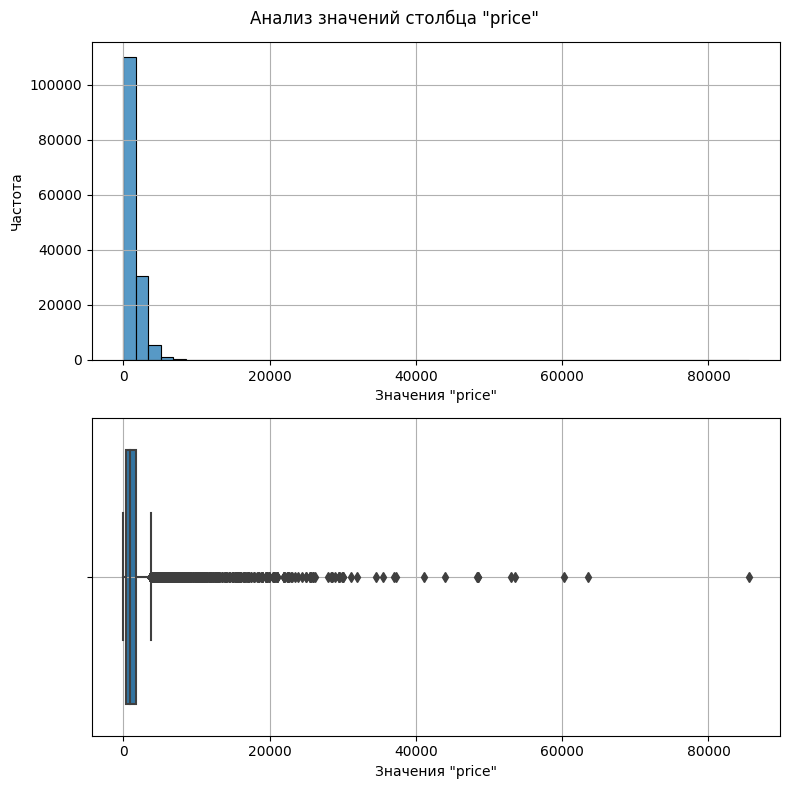

In [48]:
num_cols_analysis(purchases, 'price')

In [49]:
purchases.price.describe()

count    147168.000000
mean       1229.560074
std        1356.208905
min           1.000000
25%         399.000000
50%         999.000000
75%        1749.000000
max       85499.000000
Name: price, dtype: float64

In [50]:
purchases_price_norm_min, purchases_price_norm_max = normal_range(purchases, 'price')
purchases_price_norm_min, purchases_price_norm_max

(1.0, 3774.0)

В среднем, один товар приобретенный в интернет-магазине стоит не более 3774 у.е., при этом в половине наблюдений стоимость товара не превышает 1000 у.е. Часть товаров имеет более высокую стоимость, статистически такие товары относятся к выбросам для исследуемого набора данных. Изучим основные статистики цены товаров в зависимости от количества приобретенных единиц.

In [51]:
purchases.pivot_table(index='quantity', values='price', aggfunc=['count', 'min', 'max', 'median', 'mean'])

,count,min,max,median,mean
,price,price,price,price,price
quantity,,,,,
1,146324,1.0,85499.0,999.0,1229.013491
2,719,2.0,5999.0,1299.0,1441.097357
3,88,2.0,9499.0,299.0,895.125000
4,12,15.0,299.0,99.0,133.666667
5,3,59.0,99.0,99.0,85.666667
6,4,3.0,299.0,174.0,162.500000
7,1,1.0,1.0,1.0,1.000000
8,1,99.0,99.0,99.0,99.000000


Большинство товаров покупались по одному, размах значений цены для данного количества товаров в заказе максимальный. Самая дорогая покупка находится в этой подгруппе.

Покупки более четырех единиц товара в одном заказе редки, имеют более узкий ценовой диапозон и меньшие средние значения цены одного товара, причем с увеличением количества приобретенных единиц, среднее значение цены этих товаров имеет тенденцию снижаться.

Наблюдения, которые статистически отностяся к выбросам по исследуемым показателям мы будем использовать при обучении модели, т.к. нам важно учитывать общую сумму покупок и сумму последней покупки клиента, чтобы спрогнозировать целевой признак.

Изучим признак `category_ids`.

Ознакомимся подробнее со значениями признака и оценим количество уникальных категорий.

In [52]:
purchases.category_ids.sort_values().unique()[0:5]

array(["['1', '22', '50', '685']", "['1', '8', '280', '710']",
       "['2', '17', '107', '453']", "['2', '17', '137', '469']",
       "['2', '17', '171', '475']"], dtype=object)

In [53]:
f'Уникальных категорий товаров: {purchases.category_ids.unique().shape[0]}'

'Уникальных категорий товаров: 933'

Каждая категория представлена массивом закодированных подкатегорий. Изучим структуру кодировки признаков.

In [54]:
purchases['category_ids'] = purchases['category_ids'].str.replace(r"[\[\]']", '', regex=True).str.strip()

In [55]:
subcategories = purchases['category_ids'].str.split(', ', expand=True)

In [56]:
subcategories.head()

,0,1,2,3,4
0,4,28,57,431,None
1,4,28,57,431,None
2,4,28,57,431,None
3,4,28,244,432,None
4,4,28,49,413,None


Количество элементов в коде id товаров различается. При этом, при первичном форматировании датасета, значения `category_ids` проверялись не поэлементно. Удалим возможные артефакты из данных о структуре кодировки признака и оценим количество пропусков.

In [57]:
subcategories = format_dataset(subcategories)
subcategories = subcategories.replace({None: np.nan})
subcategories.isna().sum()

0      4019
1      4019
2      4019
3      4909
4    146785
dtype: int64

Часть товаров не содержат информации о коде категории. Чаще всего код категории состоит из трех элементов, некоторые товары имеют пятизначный номер id. Узнаем, какие уникальные значения принимает первый элемент кода категории.

In [58]:
subcategories[0].sort_values().unique()

array(['1', '2', '3', '4', '5', '5562', '5963', '6060', nan], dtype=object)

Узнаем, связан ли следующий элемент кода категории с первым.

In [59]:
for n in subcategories[0].sort_values().unique():
    print(f'{n} : {subcategories[subcategories[0] == n][1].unique()}')

1 : ['8' '22']
2 : ['18' '17']
3 : ['14' '12']
4 : ['28' '27' '31' '1822' '5837' '29' '30' '44']
5 : ['10']
5562 : ['5631' '5630' '5589' '5634' '5683' '5536' '5597' '5633' '5599' '5632'
 '5558' '5697']
5963 : ['5959']
6060 : ['6058' '6059' '6057']
nan : []


Первое значение подкатегории является уникальным ключом ко всему значению категории. Таким образом, мы можем скорректировать данный признак, оставив только первый элемент кода, который будет хранить основную информацию о категории. Это позволит модели качественнее находить взаимосвязи целевой переменной с данным признаком, если они будут. При этом в части данных будут пропущенные значения, т.к. id категории содержит неинформативные символы.

In [60]:
purchases['category_ids'] = subcategories[0]

In [61]:
purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,4,2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,4,2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,4,2022-05-16,1515915625471138230-4437-6282242f27843


In [62]:
purchases.category_ids.value_counts()

category_ids
4       83532
5562    33443
2       20244
6060     5046
5963      871
3           8
1           3
5           2
Name: count, dtype: int64

In [63]:
purchases.isna().sum()

client_id          0
quantity           0
price              0
category_ids    4019
date               0
message_id         0
dtype: int64

Код категорий обработан, часть товаров имеют пропуски по данному признаку. Определимся со стратегией заполнения этих пропусков после объединения датасетов, на этапе подготовки данных.

Исследуем зависимость целевой переменной от данных датасета с историей покупок.

In [64]:
temp_purchases_target = purchases.merge(target, on='client_id')

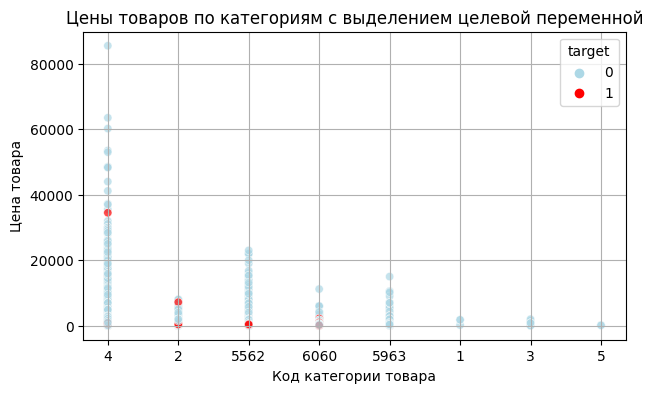

In [65]:
plt.figure(figsize=(7, 4))
plt.title('Цены товаров по категориям с выделением целевой переменной')
sns.scatterplot(data=temp_purchases_target, x='category_ids', y='price', hue='target',palette={0: 'lightblue', 1: 'red'}, alpha=0.7)
plt.xlabel('Код категории товара')
plt.ylabel('Цена товара')
plt.grid()
plt.show()

Большая часть заказов приходится на товары категории "4", размах значений цены для этих товаров наивысший, по сравнению с другими категориями. Категория "5562" также содержит дорогостоящие товары. Распределение целевого признака не отображает явной зависимости со значением какого-либо из визуализированных признаков.

In [66]:
# Удалим временную таблицу
temp_purchases_target = None

### Messages

Узнаем, данные за какой период представлены в датасете.

In [67]:
f'В датасете `messages` представлены данные за период с {messages.date.min()} по {messages.date.max()}.'

'В датасете `messages` представлены данные за период с 2022-05-19 00:00:00 по 2024-02-15 00:00:00.'

Временной интервал обоих датасетов соотетсвует.

Проверим наличие хронологических аномалий, где дата создания сообщения больше даты какого-либо действия над ним.

In [68]:
messages[messages['created_at'].dt.floor('D') > messages['date']].shape[0]

0

Таких аномалий нет. Продолжим исследование хронологической достоверности данных, рассмотрим их в разрезе значений столбца `event`. Сгруппируем данные по клиентам и id сообщения, и выведем значения даты для каждого совершенного с сообщением действия.

In [69]:
messages_by_client = messages.pivot_table(index=['client_id', 'message_id'], columns='event', values='date')
messages_by_client.tail(5)

event                                                            click  \
client_id           message_id                                           
1515915626010221592 1515915626010221592-14648-65cdb6d2ab406        NaT   
                    1515915626010221592-14653-65cdc49de879f 2024-02-15   
1515915626010234726 1515915626010234726-14656-65cdd2f839b78        NaT   
1515915626010261344 1515915626010261344-14648-65cdb6d56c4c8 2024-02-15   
1515915626010288690 1515915626010288690-14648-65cdb6d29b698        NaT   

event                                                             open other  \
client_id           message_id                                                 
1515915626010221592 1515915626010221592-14648-65cdb6d2ab406 2024-02-15   NaT   
                    1515915626010221592-14653-65cdc49de879f 2024-02-15   NaT   
1515915626010234726 1515915626010234726-14656-65cdd2f839b78        NaT   NaT   
1515915626010261344 1515915626010261344-14648-65cdb6d56c4c8 2024-02-15   NaT   
1515915626010288690 1515915626010288690-14648-65cdb6d29b698 2024-02-15   NaT   

event                                                       purchase  \
client_id           message_id                                         
1515915626010221592 1515915626010221592-14648-65cdb6d2ab406      NaT   
                    1515915626010221592-14653-65cdc49de879f      NaT   
1515915626010234726 1515915626010234726-14656-65cdd2f839b78      NaT   
1515915626010261344 1515915626010261344-14648-65cdb6d56c4c8      NaT   
1515915626010288690 1515915626010288690-14648-65cdb6d29b698      NaT   

event                                                             send  \
client_id           message_id                                           
1515915626010221592 1515915626010221592-14648-65cdb6d2ab406 2024-02-15   
                    1515915626010221592-14653-65cdc49de879f 2024-02-15   
1515915626010234726 1515915626010234726-14656-65cdd2f839b78 2024-02-15   
1515915626010261344 1515915626010261344-14648-65cdb6d56c4c8 2024-02-15   
1515915626010288690 1515915626010288690-14648-65cdb6d29b698 2024-02-15   

event                                                       subscribe  \
client_id           message_id                                          
1515915626010221592 1515915626010221592-14648-65cdb6d2ab406       NaT   
                    1515915626010221592-14653-65cdc49de879f       NaT   
1515915626010234726 1515915626010234726-14656-65cdd2f839b78       NaT   
1515915626010261344 1515915626010261344-14648-65cdb6d56c4c8       NaT   
1515915626010288690 1515915626010288690-14648-65cdb6d29b698       NaT   

event                                                       unsubscribe  
client_id           message_id                                           
1515915626010221592 1515915626010221592-14648-65cdb6d2ab406         NaT  
                    1515915626010221592-14653-65cdc49de879f         NaT  
1515915626010234726 1515915626010234726-14656-65cdd2f839b78         NaT  
1515915626010261344 1515915626010261344-14648-65cdb6d56c4c8         NaT  
1515915626010288690 1515915626010288690-14648-65cdb6d29b698         NaT

Проверим данные на наличие хронологических аномалий: 
- дата отправки позднее даты любого другого десйствия с сообщением,
- клиент открыл сообщение позднее, чем перешел по ссылке,
- клиент перешел по ссылке позднее, чем совершил покупку.

In [70]:
chronological_violations = messages_by_client[
    (messages_by_client['send'] > (messages_by_client[messages_by_client.drop('send', axis=1).columns].min(axis=1)))
    | (messages_by_client['open'] > messages_by_client['click'])
    | (messages_by_client['click'] > messages_by_client['purchase'])
]
chronological_violations.shape[0]

18071

В нашем датасете 18 тысяч строк с недостоверными данными о дате совершенного действия. Удалим эти записи по номерам id сообщений.

In [71]:
messages.shape

(12691188, 7)

In [72]:
messages = messages[~messages['message_id'].isin(chronological_violations.reset_index()['message_id'])]

In [73]:
messages.shape

(12580757, 7)

In [74]:
# Удалим временные таблицы.
messages_by_client = None
chronological_violations = None

Исслудем частоту встречаемости каждой категории и рассчитаем общую конверсию для каждого действия от отправки сообщения до совершения покупки.

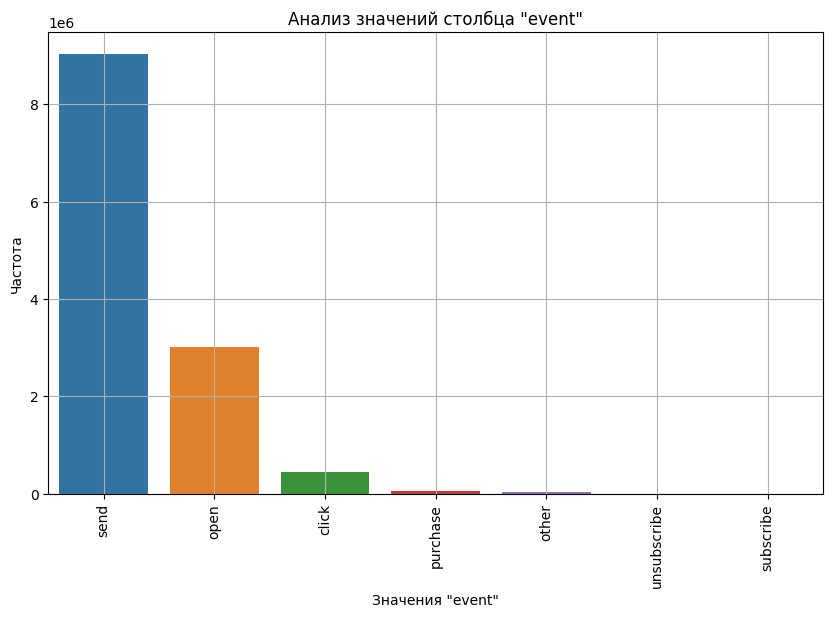

event
send           9040183
open           3006114
click           443487
purchase         56436
other            31673
unsubscribe       2783
subscribe           81
Name: count, dtype: int64

In [75]:
discret_cols_analysis(messages, 'event') 
messages.event.value_counts()

In [76]:
send = messages.event.value_counts().iloc[0]
open = messages.event.value_counts().iloc[1]
click =  messages.event.value_counts().iloc[2]
purchase =  messages.event.value_counts().iloc[3]

In [77]:
print(f'Коэффициент открытых сообщений: {(open / send * 100):.1f}%')
print(f'Коэффициент кликов по открытым сообщениям: {(click / open * 100):.1f}%')
print(f'Конверсия покупок от переходов по ссылкам: {(purchase / click * 100):.1f}%')
print(f'Конверсия покупок ко всем отправленным сообщениям: {(purchase / send * 100):.1f}%')

Коэффициент открытых сообщений: 33.3%
Коэффициент кликов по открытым сообщениям: 14.8%
Конверсия покупок от переходов по ссылкам: 12.7%
Конверсия покупок ко всем отправленным сообщениям: 0.6%


Результаты рассчетов указывают на низкую конверсию отправленных сообщений: из всех отправленных сообщений менее одного процента приводят к покупкам. В данном случае мы видим, что коэффициент открытых сообщений достаточно высок, однако далее на кадждом этапе компания теряет заинтересованность потенциальных покупателей.

Выявим наиболее успешные рассылки по количеству заказов и их общей стоимости.

In [78]:
purchases['bulk_campaign_id'] = purchases['message_id'].str.extract(r'-(\d+)-').astype(int)

In [79]:
purchases.groupby('bulk_campaign_id')['price'].agg('sum').sort_values(ascending=False).head(5)

bulk_campaign_id
7803     5342288.0
4679     5194707.0
12218    4595852.0
8902     4093953.0
13157    3355660.0
Name: price, dtype: float64

In [80]:
(
    messages
    .query('event == "purchase"')
    .groupby('bulk_campaign_id')['date'].agg('count')
    .sort_values(ascending=False).head(5)
)

bulk_campaign_id
4679     2086
12218    1234
7803     1119
5335     1008
4744      996
Name: date, dtype: int64

Наиболее успешными по количеству заказов и по прибыли являются рекламные компании "7803", "4679" и "12218". Чтобы сделать данные о прибыли каждой рекламной кампании более явными для модели, заменим код кампании на ее прибыль.

In [81]:
profits = purchases.groupby('bulk_campaign_id')['price'].agg('sum')
purchases['bulk_campaign_id'] = purchases['bulk_campaign_id'].map(profits)

In [82]:
purchases.bulk_campaign_id.isna().sum()

0

Проанализируем категории признака `channel`

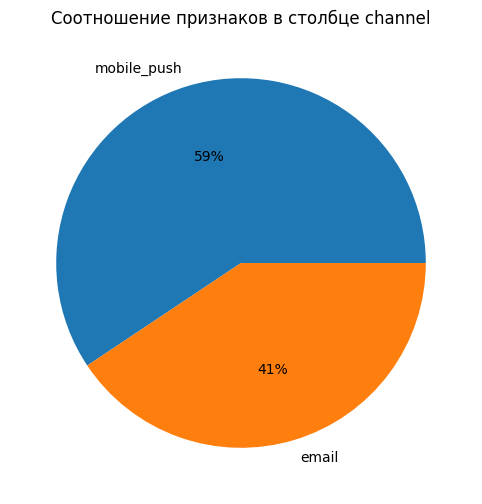

channel
mobile_push    7468244
email          5112513
Name: count, dtype: int64

In [83]:
cat_cols_analysis(messages, 'channel')

Проверим, может ли один клиент получать  уведомления и через push, и через email.

In [84]:
if len(messages.groupby(['client_id', 'channel'])) / messages['client_id'].unique().shape[0] > 1:
    print('Клиент может получать сообщения по обоим каналам коммуникации.')
else:
    print('Клиент может получать сообщения только по одному каналу коммуникации.')

Клиент может получать сообщения по обоим каналам коммуникации.


Рассчитаем конверсию покупок клиентов, получающих и email, и push уведомления и конвенрию покупок остальных клиентов в зависимости от канала коммуникации. 

In [85]:
agg = messages.groupby(['client_id'])['channel'].unique()
cross_channel_clients_id = agg[agg.apply(lambda x: len(x) > 1)].index.tolist()

In [86]:
cross_channel = messages[messages['client_id'].isin(cross_channel_clients_id)]
single_channel = messages[~messages['client_id'].isin(cross_channel_clients_id)]

In [87]:
cross_channel.shape

(7936085, 7)

In [88]:
single_channel.shape

(4644672, 7)

In [89]:
cross_channel_conversion = (cross_channel[cross_channel['event'] == 'purchase'].shape[0] /
                            cross_channel[cross_channel['event'] == 'send'].shape[0] * 100)

push_conversion = (single_channel[(single_channel['channel'] == 'mobile_push') & (single_channel['event'] == 'purchase')].shape[0] / 
                    single_channel[(single_channel['channel'] == 'mobile_push') & (single_channel['event'] == 'send')].shape[0] * 100)

email_conversion = (single_channel[(single_channel['channel'] == 'email') & (single_channel['event'] == 'purchase')].shape[0] / 
                    single_channel[(single_channel['channel'] == 'email') & (single_channel['event'] == 'send')].shape[0] * 100)

In [90]:
display(f'Конверсия покупок для кросс-канальной коммуникации: {cross_channel_conversion:.2}%')
display(f'Конверсия покупок по всем отправленным push сообщениям: {push_conversion:.2}%')
f'Конверсия покупок по всем отправленным email сообщениям: {email_conversion:.2}%'

'Конверсия покупок для кросс-канальной коммуникации: 0.46%'

'Конверсия покупок по всем отправленным push сообщениям: 0.56%'

'Конверсия покупок по всем отправленным email сообщениям: 1.4%'

Одноканальные рассылки являются более эффективным способом коммуникации, при этом конверсия email-сообщений превышает конверсию push-уведомлений почти в три раза.

In [91]:
# Удалим временные таблицы.
agg = None
cross_channel = None
single_channel = None

Изучим значения целевого признака в зависимости от данных переписки с клиентами.

In [92]:
temp_messages_target = messages.merge(target, on='client_id')

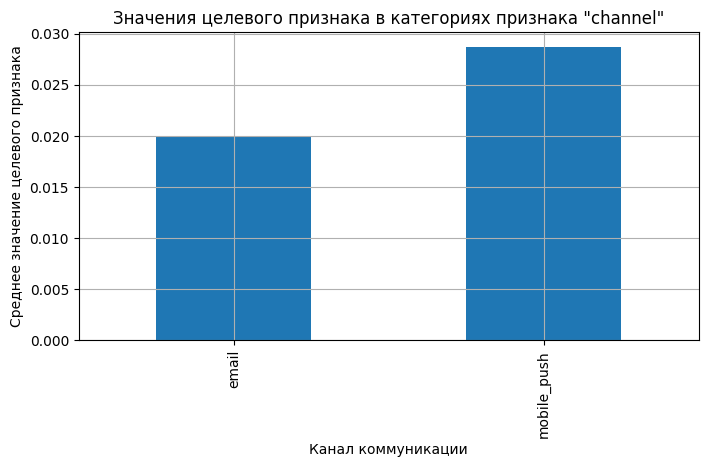

In [93]:
plt.figure(figsize=(8, 4))
plt.title('Значения целевого признака в категориях признака "channel"')
temp_messages_target.groupby('channel')['target'].agg('mean').plot(kind='bar')
plt.xlabel('Канал коммуникации')
plt.ylabel('Среднее значение целевого признака')
plt.grid()
plt.show()

Несмотря на более низкие значения конверсии, с потенциальным возвращением клиента к сервису больше связан канал "mobile_push".

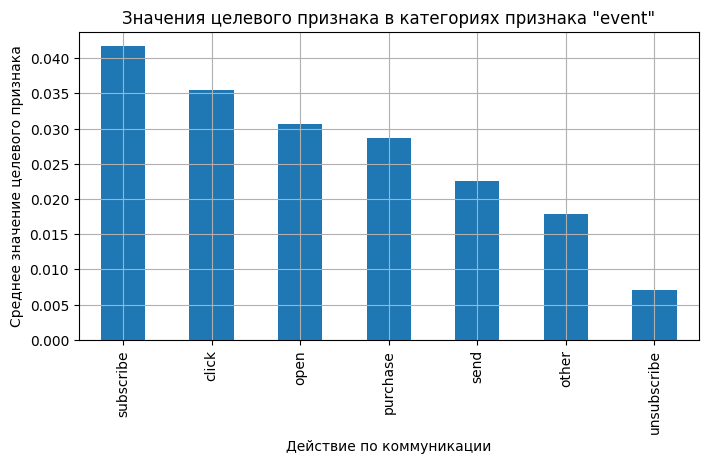

In [94]:
plt.figure(figsize=(8, 4))
plt.title('Значения целевого признака в категориях признака "event"')
temp_messages_target.groupby('event')['target'].agg('mean').sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Действие по коммуникации')
plt.ylabel('Среднее значение целевого признака')
plt.grid()
plt.show()

Количество клиентов, которые вернутся за покупками различается в каждой подкатегории признака, вероятно, данные о количестве определенных действий с сообщением будет выступать важным признаком в предсказании возвращения клиентов за покупками.

In [95]:
temp_messages_target = None

### Промежуточный итог по этапу исследовательского анализа.

Оба исследуемых датасета описывают данные собранные с мая 2022 по февраль 2024.

**Датасет `purchases`**.

В данных столбцов `price` и `quantity` мы обнаружили выбросы по значениям обоих признаков. Большинство товаров покупалось по одной единице в заказе и стоили не более 3800 у.е., однако в нашем наборе данных есть наблюдения как по более объемным закупкам, так и по более дорогостоящим товарам. Мы проанализировали средние и медианные значения цен для каждого значения количества единиц товара в заказе и не обнаружили там явных выбросов (объемных закупок дорогостоящими товарами). В связи с этим данные, относящиеся к выбросам по каждому признаку в отдельности мы сочли релевантными для дальнейшего обучения модели. 

Также, изучив структуру признака `category_ids` мы обнаружили, что первый элемент кодировки определяет последующие уникальные для него элементы. Чтобы укрупнить категории, мы использовали первое в кодировке значение в качестве основного номера категории. Также явными стали около 4000 пропущенных значений, т.к. часть наблюдений имела неинформативные символы в коде категории.

По результатам исследования зависимости целевого признака от данных датасета мы не выявили между ними явной зависимости.

**Датасет `messages`**.

Мы изучили данные датасета и избавились от хронологических ошибок. Изучив данные столбцов `event` и `channel`, мы обнаружили низкие значения конверсии покупок к отправленным сообщениям, которая составляет 0.6%, при этом коэффициент открытых сообщений достаточно высок, однако далее на кадждом этапе компания теряет заинтересованность потенциальных покупателей. Значение конверсии различается в зависимости от канала коммуникации: 
- для кросс-канальной коммуникации она составляет 0.46%
- для push-сообщений - 0.56%
- для email-сообщений - 1.4%

Помимо этого, мы выявили наиболее успешные с для заказчика рассылки, которые принесли наибольшие значения прибыли.

По результатам исследования зависимости целевого признака от данных датасета можно заключить, что количество действий с сообщением (подписка, переход по ссылке, отписка), может стать полезной информацией для предсказания целевого признака. 

In [96]:
f'Размерность датасетов после этапа исследовательского анализа. Purchases: {purchases.shape}, messages:{messages.shape}.'

'Размерность датасетов после этапа исследовательского анализа. Purchases: (147168, 7), messages:(12580757, 7).'

## Объединение таблиц

Еще раз оценим наличие пропусков в датасетах, проверим, есть ли данные в `messages` и `purchases` для всех клиентов из `target`, чтобы составить представление о потенциальных пропусках после объединения таблиц.

In [97]:
purchases.isna().sum()

client_id              0
quantity               0
price                  0
category_ids        4019
date                   0
message_id             0
bulk_campaign_id       0
dtype: int64

In [98]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [99]:
f'Клиентов из target, отсутствующих в purchases: {target[~target["client_id"].isin(purchases["client_id"])].shape[0]}'

'Клиентов из target, отсутствующих в purchases: 0'

In [100]:
f'Клиентов из target, отсутствующих в messages: {target[~target["client_id"].isin(messages["client_id"])].shape[0]}'

'Клиентов из target, отсутствующих в messages: 7874'

После объединения мы ожидаем наличие пропусков в данных о коммуникации для почти 7900 клиентов, при этом в датасете `purchases` есть пропущенные значения в признаке `category_ids`, которые также могут сохраниться после объединения.

In [101]:
f'Дубликатов в "purchases": {purchases.duplicated().sum()}, размерность датасета: {purchases.shape}'

'Дубликатов в "purchases": 24677, размерность датасета: (147168, 7)'

In [102]:
f'Дубликатов в "messages": {messages.duplicated().sum()}, размерность датасета: {messages.shape}'

'Дубликатов в "messages": 0, размерность датасета: (12580757, 7)'

Также мы сохранили часть дубликатов в датасете `purchases`.

Объединим таблицы.

In [103]:
marketing = target.merge(purchases, on='client_id', how='left').merge(messages, on=['client_id', 'message_id',], how='left')
marketing = marketing.drop(['bulk_campaign_id_y'], axis=1)
marketing = marketing.rename(columns={'date_x' : 'date_purchase', 'bulk_campaign_id_x' : 'bulk_campaign_id', 'date_y' : 'date_message'})

Изучим общую информацию о новой таблице.

In [104]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554856 entries, 0 to 554855
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         554856 non-null  int64         
 1   target            554856 non-null  int64         
 2   quantity          554856 non-null  int64         
 3   price             554856 non-null  float64       
 4   category_ids      541067 non-null  object        
 5   date_purchase     554856 non-null  datetime64[ns]
 6   message_id        554856 non-null  object        
 7   bulk_campaign_id  554856 non-null  float64       
 8   event             506967 non-null  object        
 9   channel           506967 non-null  object        
 10  date_message      506967 non-null  datetime64[ns]
 11  created_at        506967 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(4)
memory usage: 50.8+ MB


Данные успешно объединены. Проверим наличие пропусков и дубликатов.

In [105]:
marketing.isna().sum()

client_id               0
target                  0
quantity                0
price                   0
category_ids        13789
date_purchase           0
message_id              0
bulk_campaign_id        0
event               47889
channel             47889
date_message        47889
created_at          47889
dtype: int64

Пропущенные значения соответствуют ожидаемым.

In [106]:
f'Дубликатов в объединенной таблице: {marketing.duplicated().sum()}'

'Дубликатов в объединенной таблице: 108986'

In [107]:
marketing[marketing.duplicated()].head()

,client_id,target,quantity,price,category_ids,date_purchase,message_id,bulk_campaign_id,event,channel,date_message,created_at
85,1515915625468061170,0,1,7.0,NaN,2023-03-26,1515915625468061170-11144-641ad2cda77a2,1577094.0,NaN,NaN,NaT,NaT
87,1515915625468061170,0,1,2699.0,2,2023-03-26,1515915625468061170-11144-641ad2cda77a2,1577094.0,NaN,NaN,NaT,NaT
92,1515915625468061170,0,1,2199.0,4,2023-03-29,1515915625468061170-11208-6423f082d2fcb,2027469.0,send,email,2023-03-29,2023-03-29 08:33:16
93,1515915625468061170,0,1,2199.0,4,2023-03-29,1515915625468061170-11208-6423f082d2fcb,2027469.0,open,email,2023-03-29,2023-03-29 10:27:30
94,1515915625468061170,0,1,2199.0,4,2023-03-29,1515915625468061170-11208-6423f082d2fcb,2027469.0,click,email,2023-03-29,2023-03-29 10:27:50


Дубликаты в объединенном датасете подразумевают полное дублирование записей о действиях клиента с точностью до секунды. Чтобы не получить некорректные значения при дальнейшей агрегации данных, строки - дубликаты удалим. При этом обратим внимание, что часть дублирующихся наблюдений имеют пропущенные значения, которые не позволяют унифицировать записи, поэтому при удалении дубликатов мы сделаем исключение для этих строк.

In [108]:
marketing = marketing[~marketing.duplicated() | marketing.isna().any(axis=1)]

In [109]:
f'Дубликатов после удаления: {marketing.duplicated().sum()}'

'Дубликатов после удаления: 10757'

In [110]:
f'Количество клиентов из target, отсутствующих в "marketing": {target[~target["client_id"].isin(marketing["client_id"])].shape[0]}'

'Количество клиентов из target, отсутствующих в "marketing": 0'

Дубликаты обработаны, наблюдения о клиентах, интересующих бизнес, сохранены.

Далее мы сгруппируем данные по номеру id пользователя, предварительно отразив важные для нас признаки в текущем датасете. Создадим признак с информацией об общей стоимости каждого заказа, чтобы в дальнейшем при агрегации иметь возможность обращаться к этому значению.

In [111]:
marketing['total_price'] = marketing['price'] * marketing['quantity']

Также сделаем более явной связь коммуникации с клиентом с его последующими покупками.  Создадим признак с разницей между датой покупки и датой получения сообщения.

In [112]:
temp_marketing = marketing[(marketing['event'] == 'send') | (marketing['event'] == 'purchase') | (marketing['event'] == 'click')][['client_id','message_id', 'event', 'date_message']]

In [113]:
temp_marketing = temp_marketing.pivot_table(index=['client_id', 'message_id'], columns='event', values='date_message')

In [114]:
temp_marketing.head()

event                                                            click  \
client_id           message_id                                           
1515915625468060902 1515915625468060902-4617-6290657dac196  2022-05-27   
1515915625468061003 1515915625468061003-9148-63b54b04855a4  2023-01-04   
1515915625468061100 1515915625468061100-14623-65c5c55eeb9e0 2024-02-09   
1515915625468061170 1515915625468061170-11208-6423f082d2fcb 2023-03-29   
                    1515915625468061170-13157-6483192913837 2023-06-17   

event                                                         purchase  \
client_id           message_id                                           
1515915625468060902 1515915625468060902-4617-6290657dac196  2022-05-27   
1515915625468061003 1515915625468061003-9148-63b54b04855a4  2023-01-04   
1515915625468061100 1515915625468061100-14623-65c5c55eeb9e0 2024-02-10   
1515915625468061170 1515915625468061170-11208-6423f082d2fcb 2023-03-29   
                    1515915625468061170-13157-6483192913837 2023-06-17   

event                                                             send  
client_id           message_id                                          
1515915625468060902 1515915625468060902-4617-6290657dac196  2022-05-27  
1515915625468061003 1515915625468061003-9148-63b54b04855a4  2023-01-04  
1515915625468061100 1515915625468061100-14623-65c5c55eeb9e0 2024-02-09  
1515915625468061170 1515915625468061170-11208-6423f082d2fcb 2023-03-29  
                    1515915625468061170-13157-6483192913837 2023-06-09

In [115]:
temp_marketing['from_message_to_purchase'] = np.where(
    (temp_marketing['purchase'] - temp_marketing['send']).dt.days < 0, 0, (temp_marketing['purchase'] - temp_marketing['send']).dt.days
)

Изучим описательные статистики нового признака.

In [116]:
temp_marketing['from_message_to_purchase'].describe()

count    40095.000000
mean         1.802295
std         10.380627
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        511.000000
Name: from_message_to_purchase, dtype: float64

Большинство клиентов совершают покупки в этот же или на следующий день после получения рекламного сообщения, однако часть наблюдений имеют нетипично высокие значения этого признака. Изучим их подробнее.

In [117]:
temp_marketing[temp_marketing['from_message_to_purchase'] > 100]

,event,click,purchase,send,from_message_to_purchase
client_id,message_id,,,,
1515915625468072367,1515915625468072367-10289-63f35aab3db61,2023-04-06 08:00:00,2023-07-07,2023-02-20,137.0
1515915625468089739,1515915625468089739-5286-62c52c056281b,2022-12-12 00:00:00,2022-12-12,2022-07-06,159.0
1515915625468126838,1515915625468126838-7759-636df3385ee8d,2023-04-02 04:48:00,2023-05-06,2022-11-11,176.0
1515915625468144823,1515915625468144823-5286-62c52c04101d1,2023-06-16 00:00:00,2023-06-17,2022-07-06,346.0
1515915625468236020,1515915625468236020-10777-64098b2336359,2023-06-28 00:00:00,2023-06-28,2023-03-09,111.0
...,...,...,...,...,...
1515915625804760477,1515915625804760477-4956-62a9d8c09a45d,2023-10-19 00:00:00,2023-10-19,2022-06-15,491.0
1515915625811380395,1515915625811380395-7803-636dfea7034e7,2023-05-04 00:00:00,2023-06-23,2022-11-11,224.0
1515915625837970976,1515915625837970976-6633-6328152da74fb,2023-03-29 00:00:00,2023-03-30,2022-10-08,173.0


Чаще всего клиенты совершают покупку в тот же день или через день. При этом в данных есть выбросы: клиент совершил покупку только через полтора года после получения рекламного сообщения. Однако эти покупки также относятся к покупкам в результате рассылки.

Перенесем признак в основную таблицу.

In [118]:
temp_marketing = temp_marketing.reset_index()

In [119]:
marketing = marketing.merge(temp_marketing[['client_id', 'message_id', 'from_message_to_purchase']], on=['client_id', 'message_id'], how='left')

In [120]:
# Удалим временную таблицу
temp_marketing = None

### Сгруппируем данные по клиентам.

Агрегированная таблица будет содержать следующую информацию: 
- уникальный номер id клиента;
- целевой признак
- медианная стоимость всех покупок;
- цена последней покупки;
- даты первой и последней покупки;
- количество заказов;
- дата последнего рекламного сообщения;
- номер последней рекламной кампании;
- последнее действие с сообщением;
- канал последней коммуникации;
- среднее количество дней от получения сообщения до покупки.

In [121]:
marketing_agg = marketing.pivot_table(index='client_id',
                        aggfunc={
                            'target' : 'last',
                            'total_price' : ['median','last'],
                            'category_ids' : 'last',
                            'date_purchase' : ['min', 'max', 'count'],
                            'date_message' : 'last',
                            'bulk_campaign_id' : 'last',
                            'event' : 'last',
                            'channel' : 'last',
                            'from_message_to_purchase' : 'mean'
                        }
                       )

In [122]:
marketing_agg.columns = [
    'last_bulk_campaign', 'last_category', 'last_channel', 'last_communication', 'number_of_orders', 'purchase_last',
    'purchase_first', 'last_event', 'from_message_to_purchase', 'target', 'last_price', 'median_price'
]

In [123]:
marketing_agg = marketing_agg.reset_index()

In [124]:
marketing_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   last_bulk_campaign        49849 non-null  float64       
 2   last_category             49848 non-null  object        
 3   last_channel              34902 non-null  object        
 4   last_communication        34902 non-null  datetime64[ns]
 5   number_of_orders          49849 non-null  int64         
 6   purchase_last             49849 non-null  datetime64[ns]
 7   purchase_first            49849 non-null  datetime64[ns]
 8   last_event                34902 non-null  object        
 9   from_message_to_purchase  34674 non-null  float64       
 10  target                    49849 non-null  int64         
 11  last_price                49849 non-null  float64       
 12  median_price      

Данные успешно агрегированы. Проверим наличие дубликатов и соответствие данных о целевом признаке.

In [125]:
marketing_agg.duplicated().sum()

0

Дубликаты отсутствуют. Еще раз проверим наличие записей о целевых клиентах.

In [126]:
f'Клиентов из target, отсутствующих в "marketing_agg": {target[~target["client_id"].isin(marketing_agg["client_id"])].shape[0]}'

'Клиентов из target, отсутствующих в "marketing_agg": 0'

In [127]:
f'Клиентов в агрегированной таблице: {marketing_agg.client_id.unique().shape[0]}, клиентов в target: {target.client_id.unique().shape[0]}'

'Клиентов в агрегированной таблице: 49849, клиентов в target: 49849'

Необходимые строки сохранены.

In [128]:
marketing_agg = marketing_agg.set_index('client_id')

Проверим наличие пропусков.

In [129]:
marketing_agg.isna().sum()

last_bulk_campaign              0
last_category                   1
last_channel                14947
last_communication          14947
number_of_orders                0
purchase_last                   0
purchase_first                  0
last_event                  14947
from_message_to_purchase    15175
target                          0
last_price                      0
median_price                    0
dtype: int64

В сгруппированной таблице сохранилась часть пропущенных значений  в категориальных признаках, заполним их наиболее популярными для выборки значениями в пайплайне. Пропуски в признаке `from_message_to_purchase` заполним в пайплайне медианой.

In [130]:
marketing_agg = marketing_agg.replace({None: np.nan})

## Создание новых признаков

Создадим признак со средним значением частоты заказа. Для этого рассчитаем количество дней между первым и последним заказом каждого клиента и разделим его на количество всех покупок клиента.

In [131]:
marketing_agg['days_between_orders'] = (marketing_agg['purchase_last'] - marketing_agg['purchase_first']).dt.days

Изучим описательные статистики нового признака.

In [132]:
marketing_agg['days_between_orders'].describe()

count    49849.000000
mean        21.132199
std         76.842637
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        636.000000
Name: days_between_orders, dtype: float64

Большая часть клиентов совершали единовременные покупки и больше не возвращались в интернет магазин. Часть клиентов пользуется сервисом более длительное время.

Рассчитаем частоту покупок, при рассчетах учтем, что нулевые значения в количестве дней между заказами означают один день с заказом.

In [133]:
marketing_agg['average_frequency'] = (
    marketing_agg['number_of_orders'] /
    np.where(marketing_agg['days_between_orders'] == 0, 1, marketing_agg['days_between_orders']) 
) 

Создадим признаки с количеством дней, прошедших с момента последней покупки и после последней коммуникации. Отправной точной рассчетов будет день, следующий за последней датой заказа.

In [134]:
max_date = marketing_agg.purchase_last.max() + pd.Timedelta(days=1)
marketing_agg['since_last_order'] = (max_date - marketing_agg['purchase_last']).dt.days
marketing_agg['since_last_communication'] = (max_date - marketing_agg['last_communication']).dt.days

Также создадим бинарный признак с информацией о том, совершал ли клиент покупку после последней коммуникации.

In [135]:
marketing_agg['purchase_after_communication'] = (
    marketing_agg[['last_communication', 'purchase_last']].apply(
    lambda x: 1 if x['last_communication'] < x['purchase_last'] else 0, axis=1
    )
)

Чтобы не дублировать информацию о времени, столбцы с датой первого и последнего заказа и датой коммуникации удалим. 

In [136]:
marketing_agg = marketing_agg.drop(['purchase_first', 'purchase_last', 'last_communication'], axis=1)

Сделаем данные об эффективности коммуникации с каждым клиентом явными для модели, добавим количество действий клиента с сообщением в обучающие данные.

In [137]:
temp_messages = messages.pivot_table(index='client_id', columns='event', values='date', aggfunc='count').fillna(0).reset_index()
marketing_agg = marketing_agg.merge(temp_messages, on='client_id', how='left')

Аналогично добавим данные о категориях товаров, приобретенных клиентом.

In [138]:
temp_purchases = purchases.pivot_table(index='client_id', columns='category_ids', values='price', aggfunc='count').fillna(0).reset_index()
marketing_agg = marketing_agg.merge(temp_purchases, on='client_id', how='left')

Удалим временные таблицы.

In [139]:
temp_messages = None
temp_purchases = None

Установим значения `client_id` в качестве индексов.

In [140]:
marketing_agg = marketing_agg.set_index('client_id')

Проведем контрольное форматирование итогового датасета.

In [141]:
marketing_agg = format_dataset(marketing_agg)
marketing_agg = marketing_agg.replace({None: np.nan})

## Корелляционный анализ

Проведем корреляционный анализ данных.

In [142]:
marketing_agg.columns

Index(['last_bulk_campaign', 'last_category', 'last_channel',
       'number_of_orders', 'last_event', 'from_message_to_purchase', 'target',
       'last_price', 'median_price', 'days_between_orders',
       'average_frequency', 'since_last_order', 'since_last_communication',
       'purchase_after_communication', 'click', 'open', 'other', 'purchase',
       'send', 'subscribe', 'unsubscribe', '1', '2', '3', '4', '5', '5562',
       '5963', '6060'],
      dtype='object')

In [143]:
interval_cols = ['last_bulk_campaign', 'number_of_orders', 'from_message_to_purchase', 'last_price', 'median_price',
                 'days_between_orders', 'average_frequency', 'since_last_order','since_last_communication',
                 'click', 'open', 'other', 'purchase', 'send', 'subscribe', 'unsubscribe',
                 '1', '2', '3', '4', '5', '5562', '5963', '6060'] 

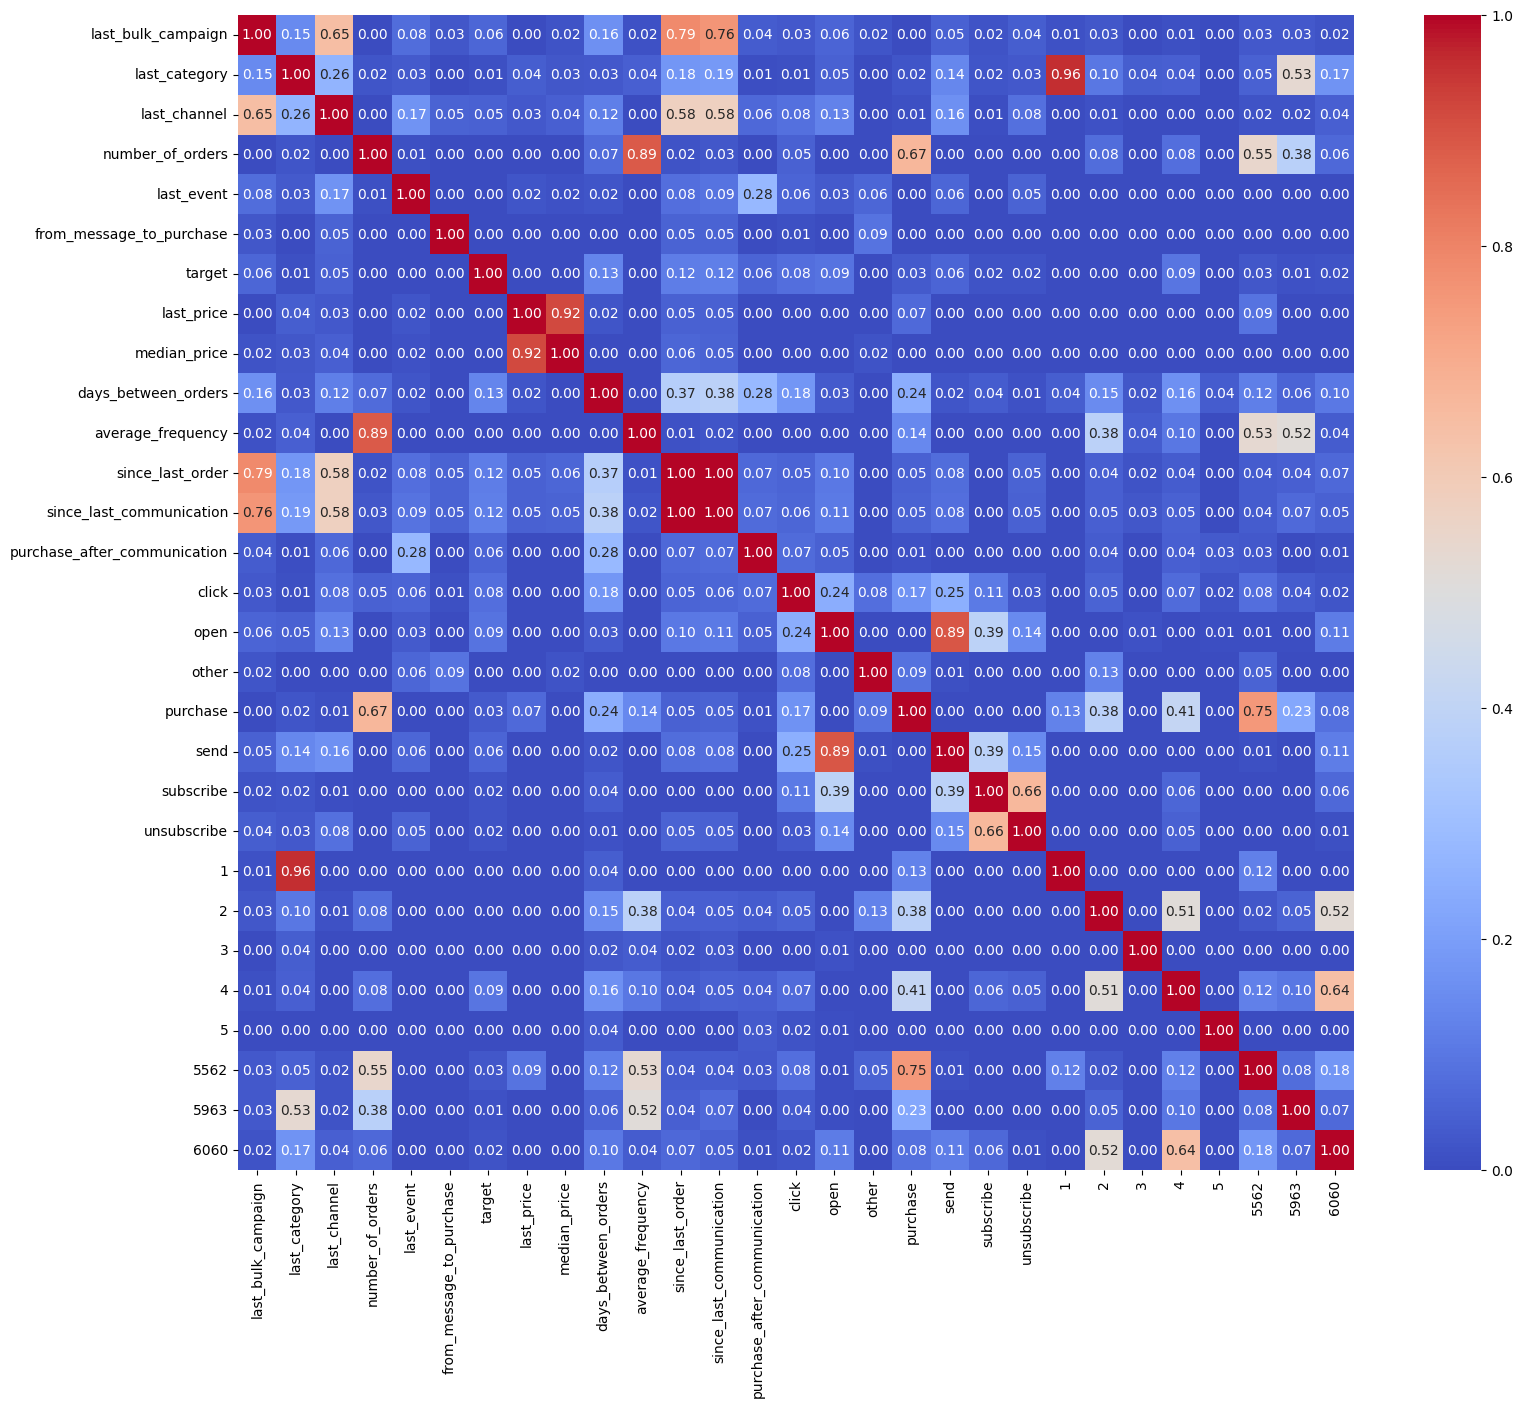

In [144]:
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(marketing_agg.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

Признаки имеют слабую связь целевой переменной. Мультиколлинеарности между признаками не наблюдается.

## Подготовка данных и обучение моделей.

Перед нами стоит задача бинарной классификации, с учетом большого количества признаков, а также значительного дисбаланса классов целевого признака, мы будем использовать бустинговые модели CatBoostClassifier и LGBMClassifier - обе модели достаточно быстро обучаются на большом количестве данных и имеют встроенные методы учета дисбаланса классов. Обучение будем проводить методом кросс-валидации с тремя стратифицированными блоками и подбором лучших гиперпараметров.

Разделим данные на обучающую и тестовую выборки.

In [145]:
X = marketing_agg.drop(['target'], axis=1)
y = marketing_agg['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [146]:
cat_columns = ['last_category', 'last_channel', 'last_event', 'purchase_after_communication']
num_columns = interval_cols

Объявим необходимые переменные: индексы категориальных признаков и вес положительного класса. Создадим класс skf, который будет отвечать за стратификацию при разбиении данных на кросс-валидации.

In [147]:
cat_idxs = list(range(0, len(cat_columns)))
pos_weight = (y_train==0).sum()/(y_train==1).sum()
skf = StratifiedKFold(n_splits=3)

Создадим пайплайны для предобработки данных и обучения моделей. При заполнении пропусков будем использовать SimpleImputer: категориальные признаки заполним наиболее частым значением, количественные данные заполним медианой. Помимо этого, для модели LGBM закодируем категориальные признаки: несмотря на наличие у модели встроенных методов кодировки, при работе с пайплайнами у нее возникают ошибки. Кодирование признаков для LGBM осуществим методом CountEncoder, чтобы не разрежевать признаковое пространство.

In [148]:
cat_pipe_lgbm = Pipeline(
    [
        ('imputer_before_encoding', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder',
         CountEncoder(handle_unknown='return_nan')),
        ('imputer_after_encoding', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

cat_pipe_cb = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

In [149]:
# Пайплайн предобработки и обучения LGBM
data_preprocessor_lgbm = ColumnTransformer(
    [
        ('cat', cat_pipe_lgbm, cat_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
) 

pipe_lgbm = Pipeline(
    [
        ('preprocessor', data_preprocessor_lgbm),
        ('models', LGBMClassifier(random_state=RANDOM_STATE,
                                  categorical_feature=cat_idxs,
                                  scale_pos_weight=pos_weight,
                                  verbose=0))
    ]
)

param_grid_lgbm = { 
    'models__n_estimators': [100, 200, 500],
    'models__learning_rate': [0.01, 0.05, 0.1],
    'models__max_depth' : range(3, 9, 2)
} 

In [150]:
# Пайплайн предобработки и обучения CatBoost
data_preprocessor_cb = ColumnTransformer(
    [
        ('cat', cat_pipe_cb, cat_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
) 

pipe_catboost = Pipeline(
    [
        ('preprocessor', data_preprocessor_cb),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE,
                                      cat_features=cat_idxs,
                                      scale_pos_weight = pos_weight,
                                      verbose=0))
    ]
)

param_grid_catboost = { 
    'models__n_estimators': [100, 200, 400],
    'models__learning_rate': [0.02, 0.03, 0.05],
    'models__max_depth' : range(3, 9, 2)
} 

## Обучение моделей

Обученим модели и оценим их качество. Заказчика интересует значение метрики roc-auc, дополнительно оценим модели метрикой f1, которая сочетает показатели точности и полноты модели.

Обучение модели LGBM.

In [151]:
grid_search_lgbm = GridSearchCV(
    pipe_lgbm,
    param_grid=param_grid_lgbm,
    scoring = 'roc_auc',
    cv=skf,
    n_jobs=-1)

grid_search_lgbm.fit(X_train, y_train)

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer_before_encoding',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          CountEncoder(combine_min_nan_groups=True,
                                                                                                       handle_unknown='return_nan')),
                                                                                         ('i...
                                                                          'send',
                                                                          'subscribe',
                                                                          'unsubscribe',
                                                                          '1',
                                                                          '2',
                                                                          '3',
                                                                          '4',
                                                                          '5',
                                                                          '5562',
                                                                          '5963',
                                                                          '6060'])])),
                                       ('models',
                                        LGBMClassifier(categorical_feature=[0,
                                                                            1,
                                                                            2,
                                                                            3],
                                                       random_state=77,
                                                       scale_pos_weight=50.84843982169391,
                                                       verbose=0))]),
             n_jobs=-1,
             param_grid={'models__learning_rate': [0.01, 0.05, 0.1],
                         'models__max_depth': range(3, 9, 2),
                         'models__n_estimators': [100, 200, 500]},
             scoring='roc_auc')

In [152]:
display(f'Параметры лучшей модели: {grid_search_lgbm.best_params_}')
print( )
display(f'Roc-auc на тренировочных данных: {grid_search_lgbm.best_score_:.2}')

y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
proba_preds_lgbm = grid_search_lgbm.predict_proba(X_test)[:, 1]

display(f'f1: {f1_score(y_test, y_pred_lgbm):.2}')
f'Roc-auc на тестовой выборке: {roc_auc_score(y_test, proba_preds_lgbm):.2}'

"Параметры лучшей модели: {'models__learning_rate': 0.01, 'models__max_depth': 3, 'models__n_estimators': 500}"

'Roc-auc на тренировочных данных: 0.73'

'f1: 0.097'

'Roc-auc на тестовой выборке: 0.76'

Общая точность модели достаточно высока, значения roc-auc на тренировочных и тестовых данных близки друг другу. Модель качественно обучилась, уловив основные характеристики клиентов и способна уловить эти закономерности на незнакомых ранее данных. Однако способность модели различать оба класса(F1-мера) очень низкая.

Обучим модель CatBoost.

In [153]:
grid_search_cb = GridSearchCV(
    pipe_catboost,
    param_grid=param_grid_catboost,
    scoring = 'roc_auc',
    cv=skf,
    n_jobs=-1
)

grid_search_cb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['last_category',
                                                                          'last_channel',
                                                                          'last_event',
                                                                          'purchase_after_communication']),
                                                                        ('num',
                                                                         Pipeline(steps...
                                                                          'since_last_communication',
                                                                          'click',
                                                                          'open',
                                                                          'other',
                                                                          'purchase',
                                                                          'send',
                                                                          'subscribe',
                                                                          'unsubscribe',
                                                                          '1',
                                                                          '2',
                                                                          '3',
                                                                          '4',
                                                                          '5',
                                                                          '5562',
                                                                          '5963',
                                                                          '6060'])])),
                                       ('models',
                                        <catboost.core.CatBoostClassifier object at 0x000002558E8A0A50>)]),
             n_jobs=-1,
             param_grid={'models__learning_rate': [0.02, 0.03, 0.05],
                         'models__max_depth': range(3, 9, 2),
                         'models__n_estimators': [100, 200, 400]},
             scoring='roc_auc')

In [154]:
display(f'Параметры лучшей модели: {grid_search_cb.best_params_}')
print( )
display(f'Roc-auc на тренировочных данных: {grid_search_cb.best_score_:.2}')

y_pred_cb = grid_search_cb.best_estimator_.predict(X_test)
proba_preds_cb = grid_search_cb.predict_proba(X_test)[:, 1]

display(f'f1: {f1_score(y_test, y_pred_cb):.2}')
f'Roc-auc на тестовой выборке: {roc_auc_score(y_test, proba_preds_cb):.2}'

"Параметры лучшей модели: {'models__learning_rate': 0.02, 'models__max_depth': 3, 'models__n_estimators': 400}"

'Roc-auc на тренировочных данных: 0.74'

'f1: 0.094'

'Roc-auc на тестовой выборке: 0.77'

Общая точность модели немного выше, чем LGBM, при этом модель имеет такие же низкие показатели среднего гармонического между точностью и полнотой. 

## Анализ и донастройка моделей.

Изучим матрицы ошибок моделей.

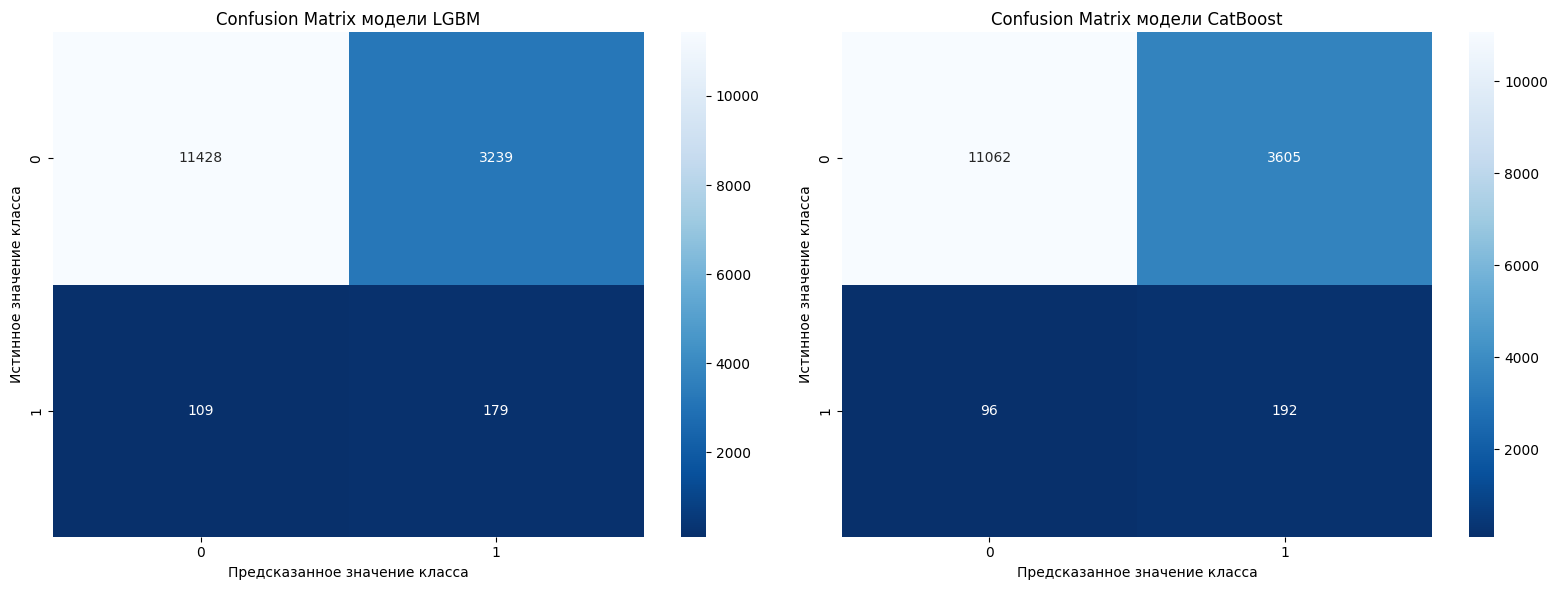

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d', cmap='Blues_r', ax=axes[0])
axes[0].set_title('Confusion Matrix модели LGBM')
axes[0].set_ylabel('Истинное значение класса')
axes[0].set_xlabel('Предсказанное значение класса')

sns.heatmap(confusion_matrix(y_test, y_pred_cb), annot=True, fmt='d', cmap='Blues_r', ax=axes[1])
axes[1].set_title('Confusion Matrix модели CatBoost')
axes[1].set_ylabel('Истинное значение класса')
axes[1].set_xlabel('Предсказанное значение класса')

plt.tight_layout()
plt.show()

Обе модели имеют примерно одинаковую струткуру ошибок: они достаточно полно определяют клиентов, которые вернутся за покупками, при этом, причисляя к их числу часть клиентов, которые к пользованию сервисом вернуться не планируют. Попробуем донастроить порог принятия решений для обеих моделей и оценить их обновленные матрицы ошибок.

In [156]:
precision_cb, recall_cb, thresholds_cb = precision_recall_curve(y_test, proba_preds_cb)

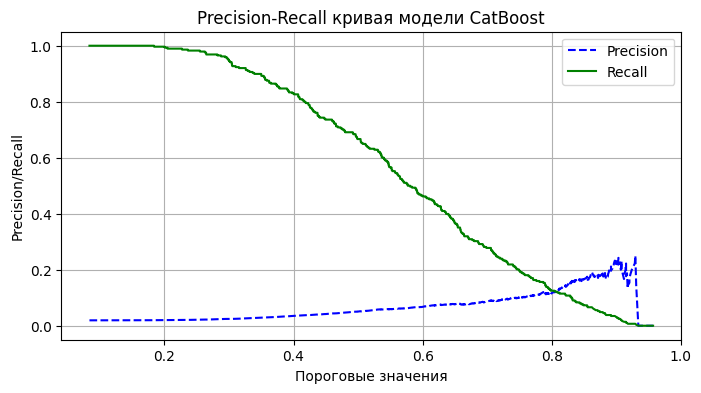

In [157]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds_cb, precision_cb[:-1], "b--", label="Precision")
plt.plot(thresholds_cb, recall_cb[:-1], "g-", label="Recall")
plt.xlabel("Пороговые значения")
plt.ylabel("Precision/Recall")
plt.title("Precision-Recall кривая модели CatBoost")
plt.legend()
plt.grid()
plt.show()

При пороговом значении 0.8, модель имеет оптимальное значение точности и полноты, при этом мы ожидаем, что количество верно предсказанных клиентов класса 1 (вернутся за покупками) при таком пороге снизится.

In [158]:
display(f'Метрика roc_auc модели: {roc_auc_score(y_test, proba_preds_cb)}')
print( )
display(f'Метрика f1 базовой модели: {f1_score(y_test, y_pred_cb)}')
display(f'Метрика precision базовой модели: {precision_score(y_test, y_pred_cb)}')
f'Метрика recall базовой модели: {recall_score(y_test, y_pred_cb)}'

'Метрика roc_auc модели: 0.7700619256759316'

'Метрика f1 базовой модели: 0.09400244798041615'

'Метрика precision базовой модели: 0.05056623650250198'

'Метрика recall базовой модели: 0.6666666666666666'

In [159]:
threshold = 0.8
y_pred_cb_corr = (proba_preds_cb >= threshold).astype(int)

In [160]:
display(f'Метрика f1 донастроенной модели: {f1_score(y_test, y_pred_cb_corr)}')
display(f'Метрика precision донастроенной модели: {precision_score(y_test, y_pred_cb_corr)}')
f'Метрика recall донастроенной модели: {recall_score(y_test, y_pred_cb_corr)}'

'Метрика f1 донастроенной модели: 0.12080536912751678'

'Метрика precision донастроенной модели: 0.11688311688311688'

'Метрика recall донастроенной модели: 0.125'

При донастроенном пороге метрика F1 остается достаточно низкой.

Изменим порог модели LGBM.

In [161]:
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(y_test, proba_preds_lgbm)

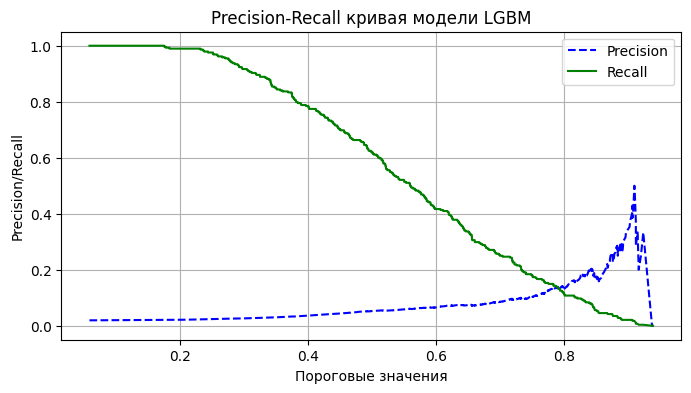

In [162]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds_lgbm, precision_lgbm[:-1], "b--", label="Precision")
plt.plot(thresholds_lgbm, recall_lgbm[:-1], "g-", label="Recall")
plt.xlabel("Пороговые значения")
plt.ylabel("Precision/Recall")
plt.title("Precision-Recall кривая модели LGBM")
plt.legend()
plt.grid()
plt.show()

In [163]:
display(f'Метрика roc_auc базовой модели: {roc_auc_score(y_test, proba_preds_lgbm)}')
print( )
display(f'Метрика f1 базовой модели: {f1_score(y_test, y_pred_lgbm)}')
display(f'Метрика precision базовой модели: {precision_score(y_test, y_pred_lgbm)}')
f'Метрика recall базовой модели: {recall_score(y_test, y_pred_lgbm)}'

'Метрика roc_auc базовой модели: 0.7633259281986016'

'Метрика f1 базовой модели: 0.09660010793308149'

'Метрика precision базовой модели: 0.05236980690462258'

'Метрика recall базовой модели: 0.6215277777777778'

In [164]:
threshold = 0.79
y_pred_lgbm_corr = (proba_preds_lgbm >= threshold).astype(int)

In [165]:
display(f'Метрика f1 донастроенной модели: {f1_score(y_test, y_pred_lgbm_corr)}')
display(f'Метрика precision донастроенной модели: {precision_score(y_test, y_pred_lgbm_corr)}')
f'Метрика recall донастроенной модели: {recall_score(y_test, y_pred_lgbm_corr)}'

'Метрика f1 донастроенной модели: 0.13793103448275862'

'Метрика precision донастроенной модели: 0.136986301369863'

'Метрика recall донастроенной модели: 0.1388888888888889'

У модели LGBM аналогичная ситуация. Изучим матрицы ошибок моделей до и после донастройки.

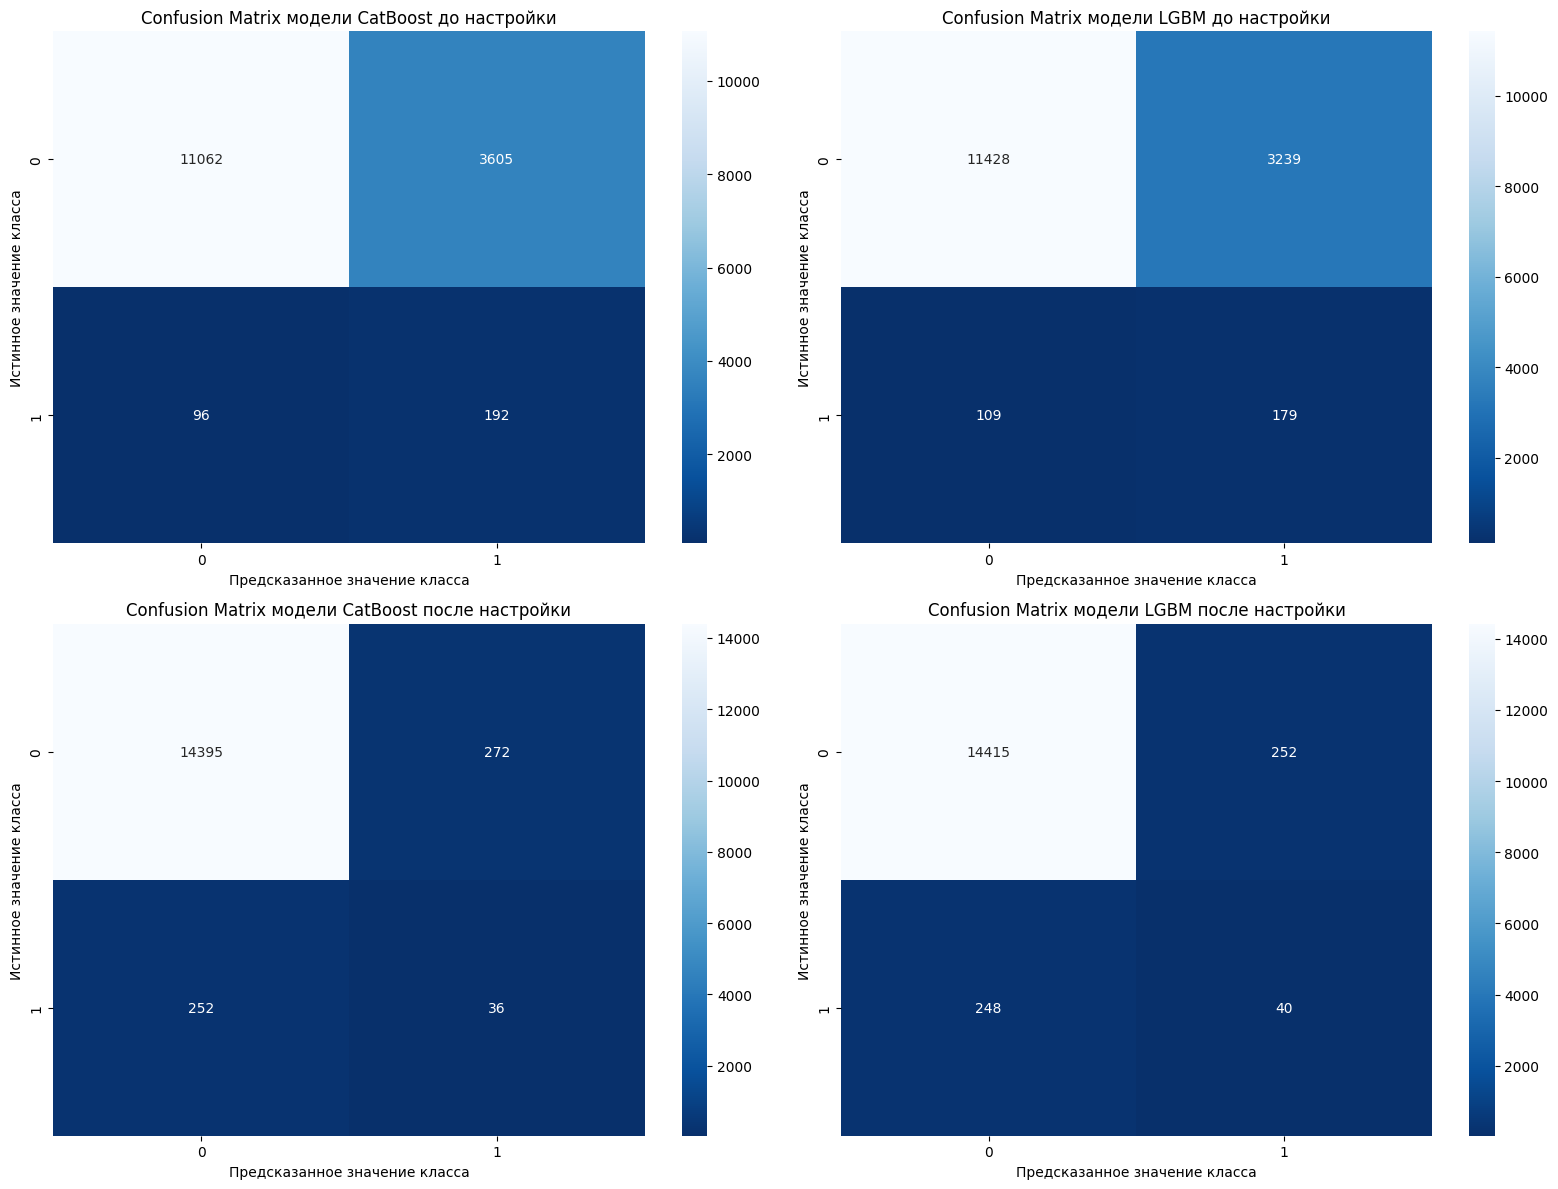

In [166]:
confusion_matrix_comp (y_test, y_pred_cb, y_pred_cb_corr, y_pred_lgbm, y_pred_lgbm_corr)

Доснастроенная модель LGBM полнее и с меньшими ошибками определяет клиентов, которые не планируют возвращаться к сервису. Наиболее полно определяет клиентов, которые вернутся за покупками, модель CatBoost без донастройки порога. Используем эту модель для итогового предсказания и в дальнейшем анализе, поскольку в техническом задании от заказчика поставлена цель - выявить клиентов, готовых совершить покупку в ближайшее время.

## Итоговое предсказание.

In [167]:
pred = grid_search_cb.best_estimator_.predict(X_test)

In [168]:
X_test['prediction'] = pred

Номера id клиентов, готовых совершить покупку:

In [169]:
list(X_test[X_test['prediction'] == 1].index)

[1515915625502277502,
 1515915625815783329,
 1515915625552786493,
 1515915625489702446,
 1515915625523981718,
 1515915625582992049,
 1515915625489197538,
 1515915625590626950,
 1515915625468179609,
 1515915625557342756,
 1515915625489084264,
 1515915625488164666,
 1515915625488078638,
 1515915625489181123,
 1515915625474034953,
 1515915625775266141,
 1515915625669858278,
 1515915625750495471,
 1515915625889112466,
 1515915625990306188,
 1515915625557013978,
 1515915625627098723,
 1515915625491053423,
 1515915625630300326,
 1515915625489644065,
 1515915625589651466,
 1515915625770561131,
 1515915625489026256,
 1515915625491815238,
 1515915625487856753,
 1515915625552661030,
 1515915625490518965,
 1515915625584961735,
 1515915625490370314,
 1515915625477654886,
 1515915625498377304,
 1515915625701220410,
 1515915625468118027,
 1515915625559365408,
 1515915625488732388,
 1515915625589576495,
 1515915625561404514,
 1515915625504261936,
 1515915625634684531,
 1515915625725310769,
 151591562

## Анализ важности признаков.

Проанализируем важность признаков с методом SHAP

In [170]:
all_features = cat_columns+num_columns
X_train_tranformed = data_preprocessor_cb.fit_transform(X_train)

In [171]:
explainer = shap.TreeExplainer(grid_search_cb.best_estimator_.named_steps['models'], 
                               feature_perturbation="tree_path_dependent",
                               feature_names=all_features)
shap_values = explainer(X_train_tranformed)

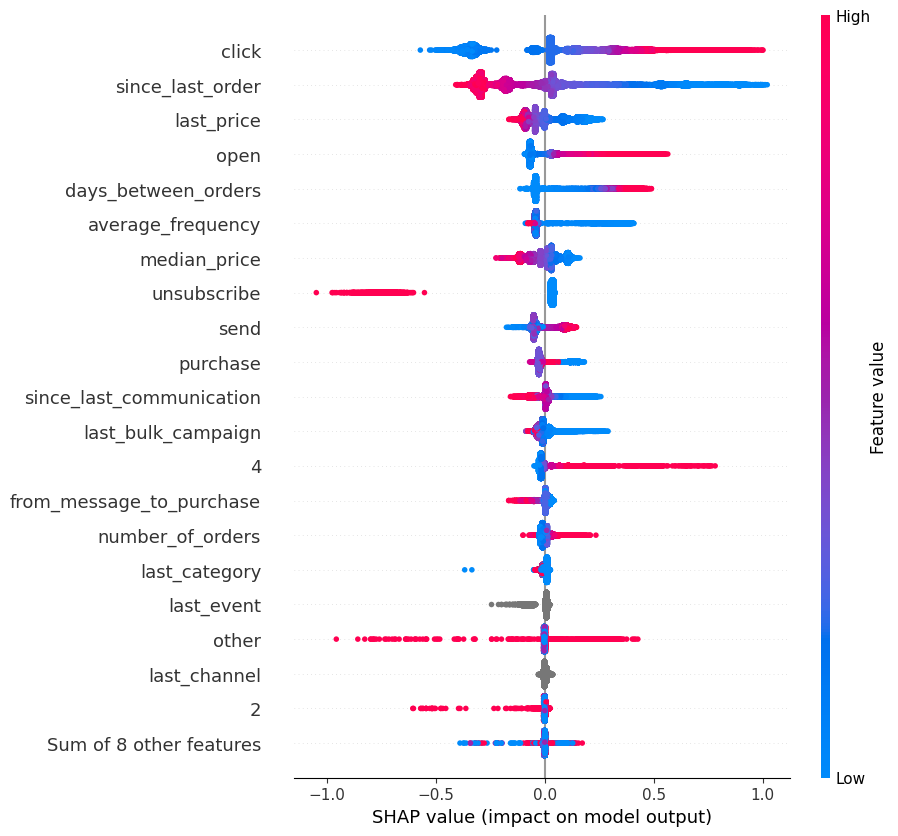

In [172]:
shap.plots.beeswarm(shap_values, max_display=21) 

Наиболее важными признаками для модели стали показатели количества переходов по ссылкам, количество дней с момента последнего заказа и цена последнего заказа. По результатам анализа SHAP-значений прослеживаются следующие закономерности для клиентов интернет-магазина:

- Клиенты, которые вернутся к сервису за покупками обычно уже пользуются сервисом какое-то время, при этом после последнего заказа прошло небольшое количество времени. Медианное значение цены всех покупок и цена последней покупки низкие, такие клиенты часто совершают покупку товаров категории "4". Эти клиенты проявляют заинтересованность в коммуникации: часто открывают сообщения и переходят по ссылкам, однако покупки по предложенным ссылкам покупают редко, при этом между получением сообщения и заказом проходит мало времени, возможно, клиенты, перейдя по ссылке и ознакомившись с предложенным товаром, совершают другие запланированные покупки. Частота заказов у этих клиентов принимает низкие значения, вероятно, в силу особенностей исследуемой выборки: большая часть клиентов совершала единоразовые покупки, например, 2 товара в один день, тогда как клиенты, возвращающиеся за покупками в течение определенного времени, имеют больший знаменатель (количество дней между первой и последней покупкой) при рассчете частоты.

- Клиенты, которые к пользованию сервисом в ближайшие 90 дней не вернутся, обнаруживают низкую заинтересованность рекламными рассылками: открытых сообщений и переходов по ссылкам мало, при этом имеют место отписки от рекламных рассылок. Частота покупок у таких клиентов высокая, а последнюю покупку они совершали достаточно давно, по отношению к дате выгрузки данных. При этом сумма заказов имеет более высокие значения, в числе популярных среди этих клиентов товаров - категория "2". То есть, такие клиенты совершают редкие дорогостоящие покупки и не интересуются другими продуктами сервиса. 

Изучим конкретные пороговые значения для наиболее важных для модели признаков.

In [173]:
columns_to_scatter = ['click', 'open', 'median_price', 'last_price', 'days_between_orders', 'since_last_order', 'average_frequency']

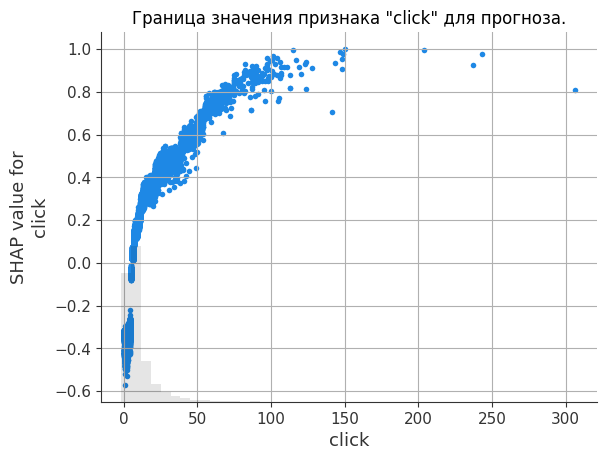

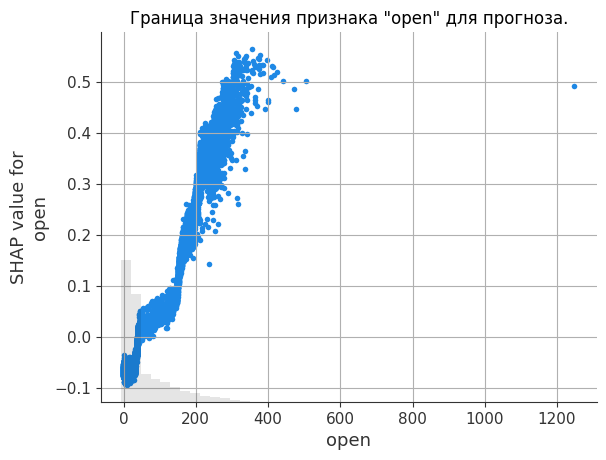

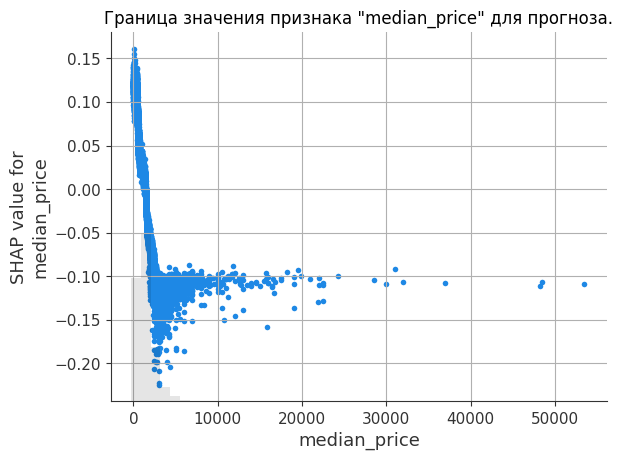

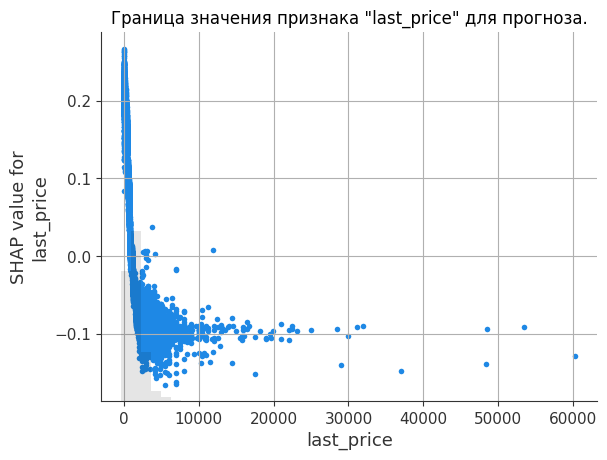

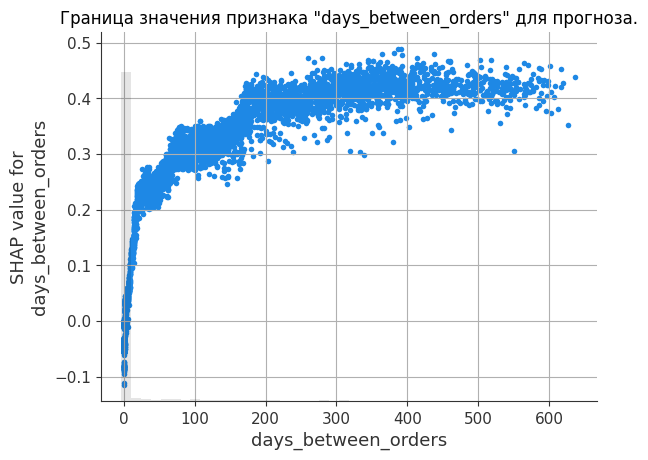

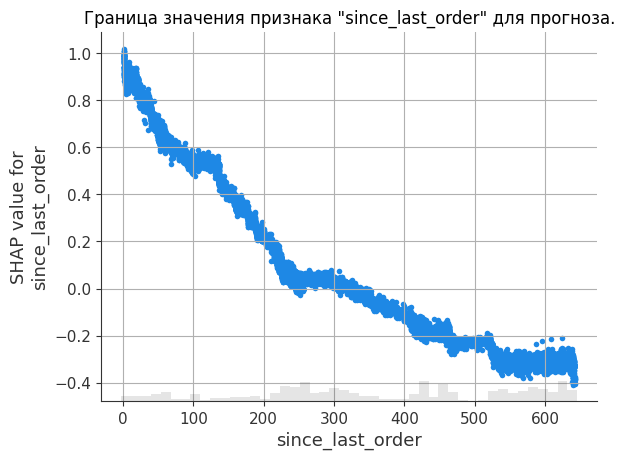

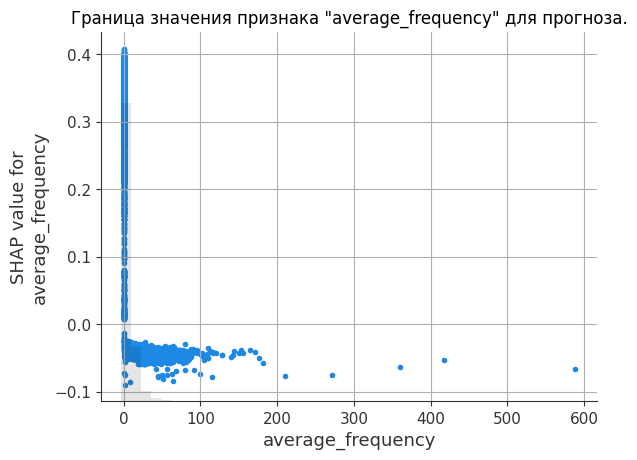

In [174]:
for col in columns_to_scatter:
    shap_scatter(col)

Клиенты, которые совершат покупки, около 200 раз открывали рекламные сообщения и более 50 раз переходили по предложенным ссылкам. Они пользуются сервисом около 100 дней и более, при этом с последнего заказа прошло менее 200 дней. Медианная стоимость заказов и цена последнего товара составляют не более 2500 у.е. Частота заказов у большинства клиентов имеет низкие значения, такова специфика наших данных, высокие значения частоты товаров дают модели уверенность в принадлежности такого наблюдения к классу 0. 

Изучим подробнее влияние частоты заказов и времени, прошежшего с последней покупки на решение модели.

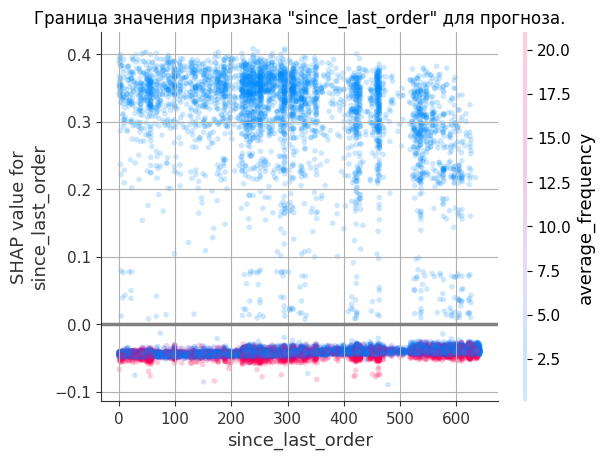

In [175]:
shap_scatter_comp('since_last_order', 'average_frequency')

В данном случае наглядно можно увидеть, как значения признака `since_last_order` дают модели мало информации о вероятном поведении клиента, но в сочетании с высокими значениями частоты заказа наблюдения разделяются на два класса уже с большей уверенностью.

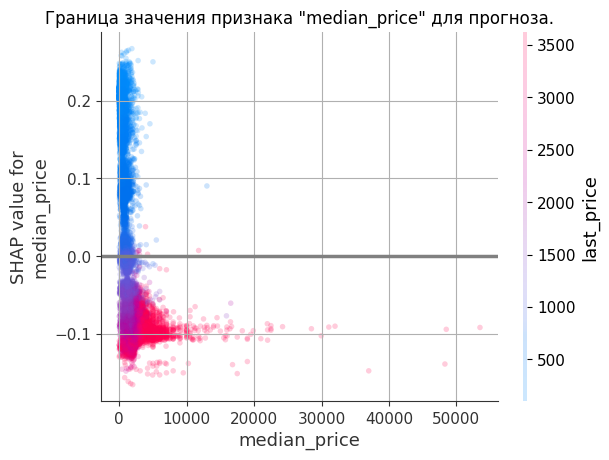

In [176]:
shap_scatter_comp('median_price', 'last_price')

Аналогично работают данные о медианной стоимости и стоимости последнего заказа: медианная стоимость всех заказов имеет достаточно узкий диапозон значений для большинства наблюдений, однако в сочетании со значениями цены последнего заказа дают модели нужную информацию: клиенты, чья последняя покупка стоила больше 2000 у.е. с большей вероятностью относятся к классу 0 (за покупками не вернутся.)

### Выводы по разделу анализа важности признаков

Анализ SHAP-значений выявил следующие факторы, влияющие на модель при предсказании возвращения клиентов в интернет-магазин. 
- **Клиенты, которые вернутся за покупками**: пользуются сервисом в течение примерно 100 дней и более, обычно имеют небольшой интервал с последнего заказа (менее 200 дней) и среднюю цену покупок ниже 2500 у.е. Они часто выбирают товары категории "4", проявляют интерес к рекламным сообщениям (открывают в среднем около 200 сообщений и переходят по ссылкам более 50 раз), однако редко совершают покупки по предложениям.

- **Клиенты, которые не вернутся**: имеют высокую частоту покупок, но совершали их давно. Эти клиенты, как правило, совершают редкие, но дорогостоящие покупки, с фокусом на товары категории "2". При этом они менее активно взаимодействуют с рекламными рассылками и нередко отписываются.

## Общий вывод

В проекте была проведена работа с заказом интернет магазина по идентификации пользователей, которые готовы совершить покупку в ближайшие 90 дней. Основу для работы составляли исторические данные заказчика о покупках и коммуникации с клиентами за период с мая 2022 года по февраль 2024 года.

В ходе исследования мы очистили датасет от некорректных и ошибочных данных, провели исследовательский анализ, по результатам которого выявилили:
- **Целевой признак :** значительный дисбаланс обучающих данных по целевому признаку (соотношение классов 98:2);
- **Данные о покупках :** большая часть клиентов совершали однократные покупки, при этом, часть из них регулировала итоговое количество единиц товара через повторные заказы. Товары чаще всего стоили не более 3800 у.е., при этом часть наблюдений составляли более дорогостоящие покупки. Наиболее популярная категория товаров среди всех клиентов - "4". 
- **Данные о коммуникации:**  мы обнаружили низкие значения конверсии покупок к отправленным сообщениям, которая составляет 0.6%, при этом коэффициент открытых сообщений достаточно высок, однако далее на кадждом этапе компания теряет заинтересованность потенциальных покупателей. Значение конверсии различается в зависимости от канала коммуникации, наиболее прибыльными являются рассылкаи по каналу email, однако с потенциальным возвращением клиента к сервису больше связан канал "mobile_push". Номера id наиболее успешных рекламных кампаний: "7803", "4679" и "12218". По результатам исследования зависимости целевого признака от данных датасета мы заключили, что количество различных действий с сообщением может стать полезной информацией для предсказания целевого признака.

Мы объединили и агрегировали данные для каждого уникального клиента и добавили новые синтетические признаки: количество дней между первым и последним заказом, частота покупок, количество дней, прошедших с момента последней покупки, количество дней, прошедших с момента последней коммуникации, бинарный признак с информацией о том, совершал ли клиент покупку после последней коммуникации, количество действий ("open", "click" и т.д.) клиента с сообщением, количество товаров к различных категориях, приобретенных клиентом.

Для **обучения** мы выбрали бустинговые модели основанные на деревьях решений: CatBoostClassifier и LGBMClassifier - они быстро обучаются на большом количестве данных и имеют встроенные методы учета дисбаланса классов. Обе модели обучались методом кросс-валидации со стратифицированным разделением на блоки и подбором гиперпараметров. Для проверки качества обученных моделей использовали метрику roc-auc - именно она интересовала заказчика, и дополнительно оценивали с помощью f1-меры.

Обе модели качественно обучились, значения roc-auc моделей на кросс-валидации и на тестовом датасета близки и составляют около 0.75. Однако способность обеих моделей различать оба класса(F1-мера) очень низкая. Мы попробовали улучшить качество модели, изменив порог принятия решений, однако итоговые модели не отвечали требованиям тз заказчика определить готовых к покупке клиентов. Для итогового предсказания мы использовали модель CatBoost, ее точность на тестовых данных составила 0.77.

Наиболее **важными признаками** для модели стали показатели количества переходов по ссылкам, количество дней с момента последнего заказа и цена последнего заказа. Анализ SHAP-значений выявил следующие закономерности в поведении исследуемых категорий клиентов:

*Клиенты, которые вернутся:* обычно активны более 100 дней, имеют интервал с последнего заказа менее 200 дней и среднюю стоимость покупок ниже 2500 у.е. Они часто выбирают товары категории "4" и проявляют интерес к рекламным сообщениям, открывая их около 200 раз и переходя по ссылкам более 50 раз, хотя редко покупают по предложениям.

*Клиенты, которые не вернутся:* их покупки, как правило, редкие и дорогие, товары часто принадлежат категории "2". Они менее активно взаимодействуют с рекламными рассылками и нередко отписываются.

По результатам анализа исходных данных и стратегии модели в принятии решений, можно выделить следующие **рекомендации для бизнеса:**

1) Проанализировать возможные причины снижения конверсии на каждом последующем шаге после отправки рекламного сообщения.
2) Поскольку email-рассылки показывают высокую эффективность, они могут послужить опорным методом удержания клиентов, при этом следует обратить внимание на эффективность канала push-уведомлений, именно с ним связано большее число клиентов, которые возвращаются за покупками. В данном контексте можно учесть высокую популярность товаров категории "4", т.к. именно за ней чаще всего возвращаются клиенты.
3) Провести дополнительны анализ успешных рекламных кампаний (id "7803", "4679" и "12218") для выявления наиболее эффективных подходов в контенте и времени рассылок.
4) Настроить сбор обратной связи у клиентов, которые не открывают сообщения или часто отписываются, чтобы понять причины низкой заинтересованности. Также обратить внимание на понятность и удобство пользования сервисом, чтобы минимизировать оформление однотипных заказов.

Для решения этой проблемы попробуем воспользоваться методами сэмплирования данных.

In [177]:
pipe_lgbm_samp = ImbPipeline(
    [
        ('preprocessor', data_preprocessor_lgbm),
        ('sampler', RandomOverSampler(random_state=RANDOM_STATE)),
        ('models', LGBMClassifier(random_state=RANDOM_STATE,
                                  categorical_feature=cat_idxs,
                                  verbose=0))
    ]
)

pipe_catboost_samp = ImbPipeline(
    [
        ('preprocessor', data_preprocessor_cb),
        ('sampler', RandomOverSampler(random_state=RANDOM_STATE)),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE,
                                      cat_features=cat_idxs,
                                      verbose=0))
    ]
)

NameError: name 'ImbPipeline' is not defined

In [ ]:
grid_search_lgbm_samp = GridSearchCV(
    pipe_lgbm_samp,
    param_grid=param_grid_lgbm,
    scoring = 'roc_auc',
    cv=3,
    n_jobs=-1)

grid_search_lgbm_samp.fit(X_train, y_train)

In [ ]:
display(f'Параметры лучшей модели: {grid_search_lgbm_samp.best_params_}')
print( )
display(f'Roc-auc на тренировочных данных: {grid_search_lgbm_samp.best_score_:.2}')

y_pred_lgbm_samp = grid_search_lgbm_samp.best_estimator_.predict(X_test)
proba_preds_lgbm_samp = grid_search_lgbm_samp.predict_proba(X_test)[:, 1]

display(f'f1: {f1_score(y_test, y_pred_lgbm_samp):.2}')
f'Roc-auc на тестовой выборке: {roc_auc_score(y_test, proba_preds_lgbm_samp):.2}'

In [ ]:
grid_search_cb_samp = GridSearchCV(
    pipe_catboost_samp,
    param_grid=param_grid_catboost,
    scoring = 'roc_auc',
    cv=3,
    n_jobs=-1
)

grid_search_cb_samp.fit(X_train, y_train)

In [ ]:
display(f'Параметры лучшей модели: {grid_search_cb_samp.best_params_}')
print( )
display(f'Roc-auc на тренировочных данных: {grid_search_cb_samp.best_score_:.2}')

y_pred_cb_samp = grid_search_cb_samp.best_estimator_.predict(X_test)
proba_preds_cb_samp = grid_search_cb_samp.predict_proba(X_test)[:, 1]

display(f'f1: {f1_score(y_test, y_pred_cb_samp):.2}')
f'Roc-auc на тестовой выборке: {roc_auc_score(y_test, proba_preds_cb_samp):.2}'

### Обычный

In [ ]:
feature_importances = pd.concat([pd.Series(grid_search_cb.best_estimator_.named_steps['models'].feature_importances_),
                                      pd.Series(all_features)], axis=1)
feature_importances.columns = ['importance', 'feature']

In [ ]:
feature_importances.sort_values(by='importance', ascending=False)

lgbm

In [ ]:
feature_importances = pd.concat([pd.Series(grid_search_lgbm.best_estimator_.named_steps['models'].feature_importances_),
                                      pd.Series(all_features)], axis=1)
feature_importances.columns = ['importance', 'feature']

In [ ]:
feature_importances.sort_values(by='importance', ascending=False)

## Исследотвательский анализ после создания новых признаков.

In [ ]:
marketing_agg.head(2)

In [ ]:
# sns.pairplot(data = marketing_agg,
#              hue = 'target',
#              corner = True,
#              palette={0: 'lightblue', 1: 'red'})\
#              .fig.suptitle('Зависимости для признаков',
#                            y = 1.08)

+ вместо price и quantity - цена общая?

категория последнего купленного товара?

покупки в event и покупки просто проверить: все ли покупки отмеченные в event есть в датасете с покупками

Определить клиентов которые вернутся, посмотреть, что у них хорошего, определить тех, кто не вернется, посмотреть то, как их можно привлечь

+ Эффективность рекламной компании.

+ Средний чек пользователя за одну покупку, сумма последней покупки.

Конверсия покупок для каждого пользователя

In [ ]:
messages_conv = marketing.groupby(['client_id', 'event'])['bulk_campaign_id'].count().unstack(fill_value=0)

In [ ]:
messages_conv = messages_conv.reset_index() 

In [ ]:
messages_conv.head(3)

In [ ]:
messages_conv['communication_conversion'] = np.where(messages_conv['send'] == 0, 1, messages_conv['purchase'] / messages_conv['send'])

In [ ]:
messages_conv.communication_conversion.describe()

Добавим столбец в основной датафрейм.

In [ ]:
marketing_agg = marketing_agg.merge(messages_conv[['client_id', 'communication_conversion']], on='client_id', how='left')
                            # .merge(temp_agg[['client_id', 'rolling_mean']], on='client_id', how='left')

In [ ]:
marketing_agg['communication_conversion'] = marketing_agg['communication_conversion'].fillna(marketing_agg['communication_conversion'].median())

In [ ]:
marketing_agg.isna().sum()

In [ ]:

# param_grid_catboost = { 
#     'models__n_estimators': [200, 400, 600],
#     'models__learning_rate': [0.01, 0.02, 0.03],
#     'models__max_depth': range(3, 8),
#     'models__l2_leaf_reg': [1, 3, 5, 7],
#     'models__subsample': [0.6, 0.8, 1.0],
# }

# {'models__subsample': 0.8,
#  'models__n_estimators': 200,
#  'models__max_depth': 3,
#  'models__learning_rate': 0.03,
#  'models__l2_leaf_reg': 7} 0.6979349129120104 . 0.7124058023302501 . 0.08
# **************************************************
# param_grid_catboost = { 
#     'models__n_estimators': [100, 200, 400],
#     'models__learning_rate': [0.02, 0.03, 0.05],
#     'models__max_depth' : range(3, 9, 2)
# } 

# {'models__n_estimators': 100,
#  'models__max_depth': 3,
#  'models__learning_rate': 0.05} 0.6990031992677846 ю 0.7108227417179913 ю 0.08
# ****************************************************
# param_grid_catboost = { 
#     'models__n_estimators': [100, 200, 500],
#     'models__learning_rate': [0.01, 0.05, 0.1],
#     'models__max_depth' : range(2, 8, 2)
# } 

In [ ]:
# Пайплайн предобработки  и обучения моделей KNeighborsClassifier и SVC
cat_pipe = Pipeline(
    [
        ('simpleImputer_before_encoding', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('cat',
         CountEncoder(handle_unknown='return_nan')),
        ('simpleImputer_after_encoding', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


num_pipe = Pipeline(
    [('scaler',
      StandardScaler())]
)


data_preprocessor_full = ColumnTransformer(
    [('cat', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)], 
    remainder='passthrough'
) 


pipe_full = Pipeline([
    ('preprocessor', data_preprocessor_full),
    ('models', KNeighborsClassifier())
])

param_grid_full = [ 
        {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 5),
        'models__weights': ['uniform', 'distance']
    }
]
#,
    # {
    #     'models': [SVC()],
    #     'models__probability': [True],
    #     'models__kernel': ['poly', 'rbf', 'sigmoid'], 
    #     'models__C': np.arange(0.01, 0.5, 0.05),
    #     'models__gamma': np.arange(0.01, 0.5, 0.05),
    #     'models__degree': [2, 3]
    # }


## Catboost из коробки

In [ ]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y,
                                                                test_size=0.4,
                                                                random_state=RANDOM_STATE,
                                                                stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid,
                                                    y_test_valid,
                                                    test_size=0.5,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_test_valid) 

In [ ]:
X_train.isna().sum()

In [ ]:
X_train = data_preprocessor_cb.fit_transform(X_train)

In [ ]:
X_valid, X_test = data_preprocessor_cb.transform(X_valid), data_preprocessor_cb.transform(X_test)

In [ ]:
cat_idxs

In [ ]:
model = CatBoostClassifier(
    # Окончание обучения, если валидационная метрика не улучшается
    eval_metric='AUC',           # Метрика для оценки
    random_state=RANDOM_STATE,
    verbose=100,
    cat_features=cat_idxs,
    scale_pos_weight = pos_weight# Вывод информации каждые 100 итераций
)

# Обучение модели с использованием eval_set для валидации


In [ ]:
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

In [ ]:
probabilities = model.predict_proba(X_test)[:, 1]
predictions = model.predict(X_test)

In [ ]:
f'Roc-auc на тестовой выборке: {roc_auc_score(y_test, probabilities)}'

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues_r')
plt.title('Confusion matrix')
plt.ylabel('Истинное значение класса')
plt.xlabel('Предсказанное значение класса'); 

Оценка важности признаков.

In [ ]:
all_features = cat_columns+num_columns

In [ ]:
feature_importances = pd.concat([pd.Series(model.get_feature_importance()),
                                      pd.Series(all_features)], axis=1)
feature_importances.columns = ['importance', 'feature']

In [ ]:
feature_importances.sort_values(by='importance', ascending=False)

In [ ]:
RocCurveDisplay.from_estimator(randomized_search_cb.best_estimator_, X_test, y_test)

In [ ]:
feature_importances.sort_values(by='importance', ascending=False)

In [ ]:
# X_train= X_train.sort_values('since_last_order')
# y_train = y_train[X_train.index]

# if np.array_equal(X_train.index, y_train.index):
#     print("Порядок индексов совпадает")
# else:
#     print("Порядок индексов не совпадает")

In [ ]:
# tscv = TimeSeriesSplit(n_splits=3)

### Optuna

In [ ]:
# !pip install optuna
from optuna.integration import OptunaSearchCV
from optuna import distributions

In [ ]:
parameters = {
    'n_estimators': distributions.IntDistribution(100, 500),  # Опция для n_estimators может быть целым числом в диапазоне
    'learning_rate': distributions.FloatDistribution(0.01, 0.1),  # Используем логарифмическое распределение для learning_rate
    'max_depth': distributions.IntDistribution(2, 10),  # Здесь max_depth тоже в диапазоне целых чисел
}

In [ ]:
oscv = OptunaSearchCV(
    pipe_lgbm,
    param_distributions = parameters,
    scoring='roc_auc',
    n_jobs=-1,
    cv=skf,
    n_trials=5,
    random_state=RANDOM_STATE
) 

In [ ]:
oscv.fit(X_train, y_train)

In [ ]:
oscv.best_score_

In [ ]:
# randomized_search_full = RandomizedSearchCV(
#     pipe_full,
#     param_distributions=param_grid_full,
#     scoring ='roc_auc',
#     cv=skf,
#     random_state=RANDOM_STATE,
#     n_iter=5,
#     n_jobs=-1
# )
# randomized_search_full.fit(X_train, y_train)

In [ ]:
randomized_search_full.cv_results_

In [ ]:
randomized_search_full.best_score_

In [ ]:
y_pred_full = randomized_search_full.best_estimator_.predict(X_test)
proba_preds_full = randomized_search_full.predict_proba(X_test)[:, 1]
f'roc-auc на тестовой выборке: {roc_auc_score(y_test, proba_preds_full)}'

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_full), annot=True, fmt='d', cmap='Blues_r')
plt.title('Confusion matrix')
plt.ylabel('Истинное значение класса')
plt.xlabel('Предсказанное значение класса'); 

In [ ]:
# y_test.value_counts()

In [ ]:
# pd.DataFrame(y_pred_full).value_counts()

- `popular_category`, `last_category` - имеют по одному пропуску, заполним его в пайплайне на моду по выборке
- `last_channel` - также заполним наиболее популярным значением.
- `last_event` -  мы знаем, что количество целевых действи с сообщением различается для разных рекламных кампаний, заполним проуски модой внутри этих групп.

In [ ]:
# class FillLastEventByCampaign(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Преобразуем тип last_bulk_campaign в строковый
#         X['last_bulk_campaign'] = X['last_bulk_campaign'].astype(str)
        
#         # Для каждой группы находим наиболее частое значение last_event
#         mode_values = X.groupby('last_bulk_campaign')['last_event'].agg(pd.Series.mode).reset_index()
#         mode_values.columns = ['last_bulk_campaign', 'most_common_event']
        
#         # Объединяем обратно с исходным DataFrame для заполнения пропусков
#         X = X.merge(mode_values, on='last_bulk_campaign', how='left')
        
#         # Заполняем NaN значениями из most_common_event
#         X['last_event'] = X['last_event'].fillna(X['most_common_event'])
        
#         # Удаляем временный столбец
#         X.drop(columns=['most_common_event'], inplace=True)
        
#         return X

In [ ]:
# marketing_2 = target.merge(messages, on='client_id', how='left').merge(purchases, on=['client_id', 'message_id'], how='left')

In [ ]:
# t_p = target.merge(purchases, on='client_id', how='left')

In [ ]:
# t_m = target.merge(messages, on='client_id', how='left')

In [ ]:
# marketing_1_bulk = target.merge(purchases, on='client_id', how='left').merge(messages, on=['client_id', 'bulk_campaign_id',], how='left')

In [ ]:
# marketing_2_bulk = target.merge(messages, on='client_id', how='left').merge(purchases, on=['client_id', 'message_id'], how='left')

In [ ]:
# t_p.duplicated().sum()

In [ ]:
# t_m.duplicated().sum()

In [ ]:
# marketing_2.duplicated().sum()

In [ ]:
# marketing_1_bulk.duplicated().sum()

In [ ]:
# marketing_2_bulk.duplicated().sum()

In [ ]:
# t_p.isna().sum()

In [ ]:
# t_m.isna().sum()

In [ ]:
# t_p_m = t_p.merge(t_m, on=['client_id', 'message_id'])

In [ ]:
# t_m_p = t_m.merge(t_p, on=['client_id', 'message_id'], how='left')

In [ ]:
# t_p_m.isna().sum()

In [ ]:
# t_m_p.isna().sum()

In [ ]:
# marketing_2.isna().sum()

In [ ]:
# marketing_1_bulk.isna().sum()

In [ ]:
# marketing_2_bulk.isna().sum()

Сделаем эти значения более явными для модели, поменяем название канала сообщений на значения конверсии.

In [ ]:
messages['channel'] = messages['channel'].replace({'mobile_push': round(push_conversion, 2), 'email': round(email_conversion, 2)})

In [ ]:
messages['channel'].value_counts()

Названия категорий успешно заменены.

In [ ]:
purchases.isin([float('inf'), float('-inf')]).sum()

In [ ]:
# import ast

In [ ]:
# purchases['category_ids'] = purchases['category_ids'].apply(lambda x: set(ast.literal_eval(x)))

In [ ]:
# # Функция для нахождения строк с одним различием
# def find_similar_sets(sets):
#     results = []
#     for i in range(len(sets)):
#         for j in range(i + 1, len(sets)):
#             if len(sets[i].symmetric_difference(sets[j])) == 1:
#                 results.append((sets[i], sets[j]))
#     return results

In [ ]:
# # Ищем пары с одним различием
# similar_sets = find_similar_sets(purchases['category_ids'].tolist())

# # Вывод результатов
# for pair in similar_sets:
#     print(pair)

In [ ]:
# for brand, group in autos[autos['Model'].notna()].groupby('Brand'):
#     unique_models = group['Model'].unique()
#     similar_pairs = []

#     for (str1, str2) in combinations(unique_models, 2):
#         similarity = fuzz.ratio(str1, str2) 
        
#         if similarity > 70: 
#             similar_pairs.append((str1, str2, similarity))

#     print(f"\nПохожие строки для бренда {brand}:")
#     for str1, str2, similarity in similar_pairs:
#         print(f"{str1} и {str2} - Схожесть: {similarity}%")

In [ ]:
# quantities = purchases.quantity.sort_values().unique()

# fig, axes = plt.subplots(quantities.shape[0], 1, figsize=(7, 3 * quantities.shape[0]))

# for i, q in enumerate(quantities):
#     axes[i].hist(purchases[purchases['quantity'] == q]['price'], bins=10)
#     axes[i].set_title(f'Распределение цен товаров, покупавшихся в количестве: {q} единиц')
#     axes[i].set_xlabel('Цена')
#     axes[i].set_ylabel('Количество покупок')

# plt.tight_layout()
# plt.show()

In [ ]:
# purchases_set = set(purchases['client_id'])
# messages_set = set(messages['client_id'])
# target_set = set(target['client_id'])

# purchases_unique = purchases_set - messages_set - target_set  # Идентификаторы, которые есть в table1, но отсутствуют в table2 и table3
# messages_unique = messages_set - purchases_set - target_set  # Идентификаторы, которые есть в table2, но отсутствуют в table1 и table3
# target_unique = target_set - purchases_set - messages_set  # Идентификаторы, которые есть в table3, но отсутствуют в table1 и table2

# # Выводим результат
# if not purchases_unique and not messages_unique and not target_unique:
#     print("Во всех трех таблицах одинаковые client_id")
# else:
#     if purchases_unique:
#         print("Номера id уникальные для purchases:", purchases_unique)
#     if messages_unique:
#         print("Номера id уникальные для messages:", messages_unique)
#     if target_unique:
#         print("Номера id уникальные для target:", target_unique)

In [ ]:
# # Преобразуем client_id в множества
# purchases_set = set(purchases['client_id'])
# messages_set = set(messages['client_id'])
# target_set = set(target['client_id'])

# diff1 = purchases_set - messages_set - target_set  # Идентификаторы, которые есть в table1, но отсутствуют в table2 и table3
# diff2 = messages_set - purchases_set - target_set  # Идентификаторы, которые есть в table2, но отсутствуют в table1 и table3
# diff3 = target_set - purchases_set - messages_set  # Идентификаторы, которые есть в table3, но отсутствуют в table1 и table2

# # Выводим результат
# if not diff1 and not diff2 and not diff3:
#     print("Во всех трех таблицах одинаковые client_id")
# else:
#     if diff1:
#         print("Идентификаторы, отсутствующие в messages и target: ", diff1)
#     if diff2:
#         print("Идентификаторы, отсутствующие в purchases и target_set: ", diff2)
#     if diff3:
#         print("Идентификаторы, отсутствующие в purchases и messages_set: ", diff3)